# TODO:

*  Wrapper for reward clipping to [-1, 1] (same reason like image normalization)
* action repeat Wrapper (4 Times)
* better reward handling for different games
* Explanations
* Adding results to a Dataframe and save to hard drive (to compare with other models)

In [1]:
!nvidia-smi

Wed Mar 24 10:59:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    Off  | 00000000:09:00.0 Off |                  N/A |
| 23%   38C    P5    13W / 250W |      0MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import gym
import numpy as np
from matplotlib import pyplot as plt

# **Auswahl des Spiels**

[Hier](https://gym.openai.com/envs/#atari) ist eine vollständige Liste der verfügbaren Spiele zu finden. Um ein Environment zu erstellen muss der vollständige Name des Spiels als String übergeben werden.

Beispiel:

```python
game = "MsPacman-v0"
```

In [3]:
# Hier kann das Spiel übergeben werden
game = "Breakout-v0"

# **Preprocessing**
[Stable Baselines](https://github.com/openai/baselines/blob/master/baselines/common/atari_wrappers.py)


### Fire Wrapper

In [4]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        gym.Wrapper.__init__(self, env) 
        self.env.reset()

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        observation, _, _, _ = self.env.step(env.unwrapped.get_action_meanings().index('FIRE'))

        return observation

In [5]:
class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info
    
    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

In [6]:
class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

In [7]:
class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

### Episodic Life Wrapper

In [8]:
class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

### Clip Reward Wrapper

In [9]:
class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)

### Resize & Grayscale Wrapper

In [10]:
from gym import spaces
import cv2

class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        :param env: (Gym Environment) the environment
        """
        gym.ObservationWrapper.__init__(self, env)
        self.width = 84
        self.height = 84
        self.observation_space = spaces.Box(low=0, high=255, shape=(self.height, self.width, 1),
                                            dtype=env.observation_space.dtype)
        
    def observation(self, frame):
        """
        returns the current observation from a frame
        :param frame: ([int] or [float]) environment frame
        :return: ([int] or [float]) the observation
        """
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (self.width, self.height), interpolation=cv2.INTER_AREA)
        return frame[:, :, None]

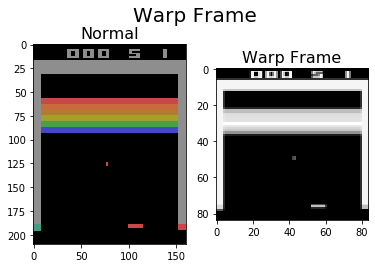

In [11]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def WarpFrameEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    return env

normal_env = gym.make(game)
wrapped_env = WarpFrameEnv(game)

normal_env.reset()
wrapped_env.reset()
action = normal_env.action_space.sample()

normal_state, _, _, _ = normal_env.step(action)
wrapped_state, _, _, _ = wrapped_env.step(action)

wrapped_state = wrapped_state[: , :, 0]

fig, axs = plt.subplots(1, 2)
fig.suptitle('Warp Frame', fontsize=20)
axs[0].imshow(normal_state)
axs[0].set_title("Normal", fontsize=16)
axs[1].imshow(wrapped_state, cmap="gray")
axs[1].set_title("Warp Frame", fontsize=16)
plt.show()

### Frame Stack Wrapper

In [12]:
from collections import deque

class FrameStack(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.frames = deque(maxlen=4)
        low = np.repeat(self.observation_space.low[np.newaxis, ...], repeats=4, axis=0)
        high = np.repeat(self.observation_space.high[np.newaxis, ...], repeats=4, axis=0)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=self.observation_space.dtype)

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack, reward, done, info

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        for _ in range(4):
            self.frames.append(obs)
        frame_stack = np.asarray(self.frames, dtype=np.float32)
        frame_stack = np.moveaxis(frame_stack, 0, -1).reshape(1, 84, 84, -1)
        return frame_stack

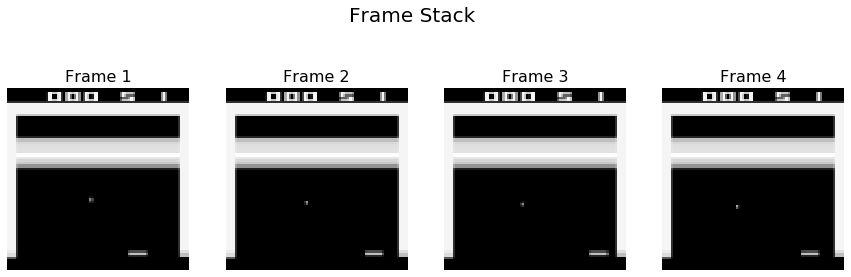

In [13]:
"""
[OPTIONAL]

Diese Zelle ist optional ausführbar und dient zur Visualisierung des Wrappers.
Die Zelle hat keinen Einfluss auf den Agenten
"""

def FrameStackEnv(env_name):
    env = gym.make(env_name)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = FrameStackEnv(game)
env.reset()

for _ in range(1, 5):
  # Führe eine zufällige Aktion aus
  state, _, _, _ = env.step(env.action_space.sample())

# Stack umformen, damit das Plotten der vier Bilder gelingt
state = state.reshape(84, 84,4)

# Frame Stack plotten
fig, axs = plt.subplots(1,4, figsize=(15, 5))
fig.suptitle('Frame Stack', fontsize=20)
for i in range(state.shape[2]):
    axs[i].imshow(state[:, :, i], cmap="gray")
    axs[i].set_title("Frame "+str(i+1), fontsize=16)
    axs[i].axis("off")
plt.show()

### Erstellen des Environments

In [14]:
def make_env(env_name):
    env = gym.make(env_name)
    #env = EpisodicLifeEnv(env)
    env = MaxAndSkipEnv(env)
    env = ScaledFloatFrame(env)
    env = NoopResetEnv(env)
    #env = ClipRewardEnv(env)
    env = WarpFrame(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    env = FrameStack(env)
    return env

env = make_env(game)


""" saving the properties for csv """
MODE = "NoEpisodicLife_NoClipReward"
PATH = "WEIGHTS/" + game + "/" + MODE + "/"
print(PATH)

WEIGHTS/Breakout-v0/NoEpisodicLife_NoClipReward/


# **Deep Q-Network und Target Network**

 *\"The input to
the neural network consists of an 84x84x4 image produced by the preprocessing
map **--w-- (falsche Darstellung)**. The first hidden layer convolves 32 filters of 8x8 with stride 4 with the
input image and applies a rectifier nonlinearity. The second hidden layer convolves
64 filters of 4x4 with stride 2, again followed by a rectifier nonlinearity.
This is followed by a third convolutional layer that convolves 64 filters of 333 with
stride 1 followed by a rectifier. The final hidden layer is fully-connected and consists
of 512 rectifier units. The output layer is a fully-connected linear layer with a
single output for each valid action. The number of valid actions varied between 4
and 18 on the games we considered."*


[Mnih, V., Kavukcuoglu, K., Silver, D. et al. Human-level control through deep reinforcement learning. Nature 518, 529–533 (2015).](https://www.nature.com/articles/nature14236)

In [15]:
import tensorflow as tf
"""
# Tell TF to not use all GPU RAM
config = tf.compat.v1.ConfigProto
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = .2
session = tf.Session(config=config)
"""
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import RMSprop, Adam

# DQN und Tagret Net Parameters
INPUT_SHAPE = (84, 84, 4) # (Höhe, Breite, Frames)
OUTPUT_SHAPE = env.action_space.n # Anzahl der möglichen Aktionen
LOSS_FUNCTION = "mean_squared_error" # Huber
OPTIMIZER = Adam(lr=0.00005)#RMSprop(learning_rate=0.00025, rho=0.95, epsilon=0.01)

# Funktion zum erstellen eines neuronalen Netzes
def build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER):
    net_input = Input(shape=INPUT_SHAPE)
    x = Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same")(net_input)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same")(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same")(x)
    x = Activation("relu")(x)
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Activation("relu")(x)
    net_output = Dense(OUTPUT_SHAPE)(x)

    model = Model(inputs=net_input, outputs=net_output)
    model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER)

    return model

# Deep Q-Network
DQN = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)
# Target Network
TARGET = build_neural_net(INPUT_SHAPE, OUTPUT_SHAPE, LOSS_FUNCTION, OPTIMIZER)

In [16]:
#DQN.summary()
#TARGET.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 84, 84, 4)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 21, 21, 32)        8224      
_________________________________________________________________
activation (Activation)      (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        32832     
_________________________________________________________________
activation_1 (Activation)    (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 11, 11, 64)        0     

# **Memory Buffer**

In [17]:
MEMORY_SIZE = 25000#1000000
MEMORY_BUFFER = deque(maxlen=MEMORY_SIZE)
TRAIN_START = 32#50000

# Speichert Transition von einem State in einen Folgestate
def save_transition(state, action, reward, next_state, done):
    MEMORY_BUFFER.append([state, action, reward, next_state, done])

# **Experience Replay**

In [18]:
import random
MINIBATCH_SIZE = 32
GAMMA = 0.99

def replay():

    # Ziehe 32 (MINIBATCH_SIZE) zufällige Transitionen aus dem Buffer in einen Minibatch
    minibatch = random.sample(MEMORY_BUFFER, MINIBATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*minibatch)

    states = np.concatenate(states)
    next_states = np.concatenate(next_states)

    q_values = DQN.predict(states)
    q_values_next = TARGET.predict(next_states)

    # Q-Values Update
    for i in range(MINIBATCH_SIZE):
        a = actions[i]
        done = dones[i]
        if done:
            q_values[i][a] = rewards[i]
        else:
            q_values[i][a] = rewards[i] + GAMMA * np.max(q_values_next[i])

    DQN.fit(states, q_values, batch_size=MINIBATCH_SIZE, verbose=0)

# **Aktion wählen**
Exploration & Exploitation

In [19]:
def linear(epsilon, decay, epsilon_min, decay_step):
    return epsilon - decay

def exponential(epsilon, decay, epsilon_min, decay_step):
    epsilon = 1
    return epsilon_min + (epsilon - epsilon_min) * np.exp(-decay * decay_step)

def epsilon_decay(mode, epsilon, decay, epsilon_min, decay_step):
    decay_strategy = {
        "linear": linear,
        "exponential": exponential
    }
    strategy = decay_strategy.get(mode)
    return strategy(epsilon, decay, epsilon_min, decay_step)

Aktion auf Basis der Explorationsstrategie wählen

In [20]:
EPSILON = 1.0
EPSILON_MIN = 0.1
#EPSILON_STEPS = 1000000
EPSILON_DECAY = 0.00002 #0.0000009

def get_action(state):
    if np.random.rand() <= EPSILON:
        return np.random.randint(env.action_space.n)
    else:
        return np.argmax(DQN(state))

In [21]:
# Initial Mean Reward -> Mean Reward kann nich auf 0 gesetzt werden (Pong -21)
INITIAL_MEAN_REWARD = 0.0
env.reset()
while True:
    _, reward, done, _ = env.step(env.action_space.sample())
    INITIAL_MEAN_REWARD += reward
    if done:
        break
INITIAL_MEAN_REWARD

1.0

# **Training des Agenten**

In [22]:
EPISODES = 15000
REWARD_LIST = []
MEAN_LIST = []
BEST_MEAN_REWARD = INITIAL_MEAN_REWARD
EPSILON_LIST = []
STEPS = 0
SYNC = 1000 #10000

for episode in range(EPISODES):
    EPISODE_REWARD = 0.0
    state = env.reset()
    done = False
    
    while not done:
        action = get_action(state)
        next_state, reward, done, _ = env.step(action)
        
        # Transition im MEMORY BUFFER speichern
        save_transition(state, action, reward, next_state, done)
        
        # Experience Replay, falls genügend Transitionen gespeichert
        if len(MEMORY_BUFFER) > TRAIN_START:
            replay()
            
        # Synchronisation zwischen Target Networks und Deep Q-Network (alle 1000 Updates - Algorithm 1)
        if STEPS % SYNC == 0:
            TARGET.set_weights(DQN.get_weights())

        # Reward einer Aktion zum gesamten Reward der Episode addieren
        EPISODE_REWARD += reward
        
        # State aktualisieren
        state = next_state
        STEPS += 1
        
        # EPSILON verringern
        if EPSILON > EPSILON_MIN:
            EPSILON = epsilon_decay("exponential", EPSILON, EPSILON_DECAY, EPSILON_MIN, STEPS)

        if done:
            REWARD_LIST.append(EPISODE_REWARD)
            current_mean_reward = np.mean(REWARD_LIST[-min(len(REWARD_LIST), 10):])
            MEAN_LIST.append(np.mean(REWARD_LIST))
            
            EPSILON_LIST.append(EPSILON)
            print("Episode:", episode+1, "\tReward:", EPISODE_REWARD, "\tMean:", round(current_mean_reward, 2),"\tBestMean:", BEST_MEAN_REWARD, "\tTRAIN START:", (len(MEMORY_BUFFER)>TRAIN_START), "\tEpsi:", EPSILON)

            # Übernahme des höchsteb Mean Rewards
            if current_mean_reward > BEST_MEAN_REWARD:
                BEST_MEAN_REWARD = current_mean_reward
        
                # Trainierte Gewichte speichern
                if EPSILON < 0.3:
                    import os
                    try:
                        os.makedirs(PATH)
                    except FileExistsError:
                        # Pfad existiert bereits
                        pass
                    DQN.save_weights(PATH +"Ep_"+ str(episode+1)+ ".h5")

W0324 10:59:57.778416 140238218639168 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:466: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


Episode: 1 	Reward: 3.0 	Mean: 3.0 	BestMean: 1.0 	TRAIN START: True 	Epsi: 0.9976117148927386
Episode: 2 	Reward: 0.0 	Mean: 1.5 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.9966736579857997
Episode: 3 	Reward: 3.0 	Mean: 2.0 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.9948977285143003
Episode: 4 	Reward: 1.0 	Mean: 1.75 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.9938454073232336
Episode: 5 	Reward: 0.0 	Mean: 1.4 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.9928525914299466
Episode: 6 	Reward: 3.0 	Mean: 1.67 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.9909088306557812
Episode: 7 	Reward: 1.0 	Mean: 1.57 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.9898608151489137
Episode: 8 	Reward: 1.0 	Mean: 1.5 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.9888333073601929
Episode: 9 	Reward: 2.0 	Mean: 1.56 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.9874004946082723
Episode: 10 	Reward: 2.0 	Mean: 1.6 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.9858538914293842
Episode: 11 	Reward: 1.0 	Mean: 1.4 	BestMean

Episode: 87 	Reward: 4.0 	Mean: 1.3 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.8883480136268941
Episode: 88 	Reward: 3.0 	Mean: 1.6 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.8866303855728352
Episode: 89 	Reward: 4.0 	Mean: 1.8 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.8846567191284681
Episode: 90 	Reward: 2.0 	Mean: 2.0 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.8834297779217295
Episode: 91 	Reward: 2.0 	Mean: 1.9 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.8821528470123606
Episode: 92 	Reward: 1.0 	Mean: 1.8 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.8809638966479215
Episode: 93 	Reward: 2.0 	Mean: 1.9 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.8797421955277633
Episode: 94 	Reward: 2.0 	Mean: 2.0 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.8785222279920594
Episode: 95 	Reward: 2.0 	Mean: 2.2 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.8773382844263825
Episode: 96 	Reward: 1.0 	Mean: 2.3 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.8762758438030143
Episode: 97 	Reward: 1.0 	Mean: 2.0 	Bes

Episode: 172 	Reward: 0.0 	Mean: 0.6 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.7896012870132539
Episode: 173 	Reward: 0.0 	Mean: 0.5 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.7888628242965392
Episode: 174 	Reward: 1.0 	Mean: 0.3 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.7880789840422454
Episode: 175 	Reward: 3.0 	Mean: 0.6 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.7866976854126866
Episode: 176 	Reward: 2.0 	Mean: 0.8 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.7856709985480593
Episode: 177 	Reward: 1.0 	Mean: 0.9 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.784844520248243
Episode: 178 	Reward: 3.0 	Mean: 1.2 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.7834079633367871
Episode: 179 	Reward: 2.0 	Mean: 1.3 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.7821265146766525
Episode: 180 	Reward: 3.0 	Mean: 1.5 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.7806342096445542
Episode: 181 	Reward: 2.0 	Mean: 1.7 	BestMean: 3.0 	TRAIN START: True 	Epsi: 0.7796460276294951
Episode: 182 	Reward: 0.0 	Mean

Episode: 257 	Reward: 1.0 	Mean: 3.1 	BestMean: 4.2 	TRAIN START: True 	Epsi: 0.6991435857275636
Episode: 258 	Reward: 1.0 	Mean: 2.4 	BestMean: 4.2 	TRAIN START: True 	Epsi: 0.6983833707114255
Episode: 259 	Reward: 1.0 	Mean: 2.3 	BestMean: 4.2 	TRAIN START: True 	Epsi: 0.6976782187484641
Episode: 260 	Reward: 1.0 	Mean: 2.2 	BestMean: 4.2 	TRAIN START: True 	Epsi: 0.6969467213519115
Episode: 261 	Reward: 0.0 	Mean: 1.8 	BestMean: 4.2 	TRAIN START: True 	Epsi: 0.6962701129911241
Episode: 262 	Reward: 1.0 	Mean: 1.9 	BestMean: 4.2 	TRAIN START: True 	Epsi: 0.6955131144628813
Episode: 263 	Reward: 1.0 	Mean: 1.6 	BestMean: 4.2 	TRAIN START: True 	Epsi: 0.6946490108206788
Episode: 264 	Reward: 2.0 	Mean: 1.0 	BestMean: 4.2 	TRAIN START: True 	Epsi: 0.6935839070371482
Episode: 265 	Reward: 5.0 	Mean: 1.3 	BestMean: 4.2 	TRAIN START: True 	Epsi: 0.6920767677116146
Episode: 266 	Reward: 3.0 	Mean: 1.6 	BestMean: 4.2 	TRAIN START: True 	Epsi: 0.6909486266456932
Episode: 267 	Reward: 1.0 	Mea

Episode: 342 	Reward: 6.0 	Mean: 4.0 	BestMean: 5.8 	TRAIN START: True 	Epsi: 0.6051876538841494
Episode: 343 	Reward: 4.0 	Mean: 4.1 	BestMean: 5.8 	TRAIN START: True 	Epsi: 0.604111898599371
Episode: 344 	Reward: 3.0 	Mean: 4.4 	BestMean: 5.8 	TRAIN START: True 	Epsi: 0.6031314144470219
Episode: 345 	Reward: 6.0 	Mean: 4.5 	BestMean: 5.8 	TRAIN START: True 	Epsi: 0.6017452119159836
Episode: 346 	Reward: 4.0 	Mean: 4.4 	BestMean: 5.8 	TRAIN START: True 	Epsi: 0.600733855382599
Episode: 347 	Reward: 2.0 	Mean: 4.0 	BestMean: 5.8 	TRAIN START: True 	Epsi: 0.6000257920854671
Episode: 348 	Reward: 5.0 	Mean: 4.1 	BestMean: 5.8 	TRAIN START: True 	Epsi: 0.5986932657563708
Episode: 349 	Reward: 5.0 	Mean: 4.3 	BestMean: 5.8 	TRAIN START: True 	Epsi: 0.5973753481074879
Episode: 350 	Reward: 7.0 	Mean: 4.4 	BestMean: 5.8 	TRAIN START: True 	Epsi: 0.5959452313219779
Episode: 351 	Reward: 3.0 	Mean: 4.5 	BestMean: 5.8 	TRAIN START: True 	Epsi: 0.5949439579799065
Episode: 352 	Reward: 4.0 	Mean:

Episode: 427 	Reward: 5.0 	Mean: 5.4 	BestMean: 5.9 	TRAIN START: True 	Epsi: 0.5156314328951692
Episode: 428 	Reward: 6.0 	Mean: 5.2 	BestMean: 5.9 	TRAIN START: True 	Epsi: 0.5143939018712586
Episode: 429 	Reward: 7.0 	Mean: 5.3 	BestMean: 5.9 	TRAIN START: True 	Epsi: 0.5130411167421056
Episode: 430 	Reward: 6.0 	Mean: 5.6 	BestMean: 5.9 	TRAIN START: True 	Epsi: 0.5115642098598827
Episode: 431 	Reward: 13.0 	Mean: 6.6 	BestMean: 5.9 	TRAIN START: True 	Epsi: 0.5099251241957581
Episode: 432 	Reward: 8.0 	Mean: 7.0 	BestMean: 6.6 	TRAIN START: True 	Epsi: 0.5085357107440146
Episode: 433 	Reward: 3.0 	Mean: 6.8 	BestMean: 7.0 	TRAIN START: True 	Epsi: 0.5077059055699925
Episode: 434 	Reward: 7.0 	Mean: 6.6 	BestMean: 7.0 	TRAIN START: True 	Epsi: 0.5062741559109046
Episode: 435 	Reward: 11.0 	Mean: 7.0 	BestMean: 7.0 	TRAIN START: True 	Epsi: 0.504400755657653
Episode: 436 	Reward: 1.0 	Mean: 6.7 	BestMean: 7.0 	TRAIN START: True 	Epsi: 0.503897240744907
Episode: 437 	Reward: 5.0 	Mea

Episode: 512 	Reward: 3.0 	Mean: 5.0 	BestMean: 8.5 	TRAIN START: True 	Epsi: 0.4301293393026779
Episode: 513 	Reward: 2.0 	Mean: 4.1 	BestMean: 8.5 	TRAIN START: True 	Epsi: 0.4295965175707492
Episode: 514 	Reward: 5.0 	Mean: 4.0 	BestMean: 8.5 	TRAIN START: True 	Epsi: 0.42873726741229146
Episode: 515 	Reward: 11.0 	Mean: 4.8 	BestMean: 8.5 	TRAIN START: True 	Epsi: 0.42743139866091545
Episode: 516 	Reward: 4.0 	Mean: 4.7 	BestMean: 8.5 	TRAIN START: True 	Epsi: 0.42667428059748225
Episode: 517 	Reward: 6.0 	Mean: 4.9 	BestMean: 8.5 	TRAIN START: True 	Epsi: 0.42576434971200805
Episode: 518 	Reward: 3.0 	Mean: 4.9 	BestMean: 8.5 	TRAIN START: True 	Epsi: 0.4250589336334739
Episode: 519 	Reward: 3.0 	Mean: 4.7 	BestMean: 8.5 	TRAIN START: True 	Epsi: 0.4244679790921574
Episode: 520 	Reward: 7.0 	Mean: 4.6 	BestMean: 8.5 	TRAIN START: True 	Epsi: 0.4234257966994847
Episode: 521 	Reward: 2.0 	Mean: 4.6 	BestMean: 8.5 	TRAIN START: True 	Epsi: 0.42293391733493313
Episode: 522 	Reward: 2.

Episode: 597 	Reward: 4.0 	Mean: 5.4 	BestMean: 8.5 	TRAIN START: True 	Epsi: 0.3596964999184291
Episode: 598 	Reward: 2.0 	Mean: 4.6 	BestMean: 8.5 	TRAIN START: True 	Epsi: 0.35924161145187755
Episode: 599 	Reward: 3.0 	Mean: 4.4 	BestMean: 8.5 	TRAIN START: True 	Epsi: 0.35876023022517495
Episode: 600 	Reward: 4.0 	Mean: 4.5 	BestMean: 8.5 	TRAIN START: True 	Epsi: 0.35812395927444823
Episode: 601 	Reward: 3.0 	Mean: 4.7 	BestMean: 8.5 	TRAIN START: True 	Epsi: 0.3576171535348673
Episode: 602 	Reward: 2.0 	Mean: 4.5 	BestMean: 8.5 	TRAIN START: True 	Epsi: 0.35719876771730014
Episode: 603 	Reward: 5.0 	Mean: 3.8 	BestMean: 8.5 	TRAIN START: True 	Epsi: 0.35651158339747857
Episode: 604 	Reward: 5.0 	Mean: 3.7 	BestMean: 8.5 	TRAIN START: True 	Epsi: 0.35581908305592275
Episode: 605 	Reward: 2.0 	Mean: 3.4 	BestMean: 8.5 	TRAIN START: True 	Epsi: 0.3554096335895544
Episode: 606 	Reward: 5.0 	Mean: 3.5 	BestMean: 8.5 	TRAIN START: True 	Epsi: 0.3546256926156066
Episode: 607 	Reward: 4.

Episode: 682 	Reward: 2.0 	Mean: 8.4 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.2992737746019954
Episode: 683 	Reward: 16.0 	Mean: 9.1 	BestMean: 9.0 	TRAIN START: True 	Epsi: 0.2983481231020483
Episode: 684 	Reward: 6.0 	Mean: 9.0 	BestMean: 9.1 	TRAIN START: True 	Epsi: 0.29768088860826836
Episode: 685 	Reward: 3.0 	Mean: 8.5 	BestMean: 9.1 	TRAIN START: True 	Epsi: 0.29723140974490336
Episode: 686 	Reward: 3.0 	Mean: 8.0 	BestMean: 9.1 	TRAIN START: True 	Epsi: 0.2967549815658315
Episode: 687 	Reward: 6.0 	Mean: 7.3 	BestMean: 9.1 	TRAIN START: True 	Epsi: 0.29610260991067666
Episode: 688 	Reward: 8.0 	Mean: 7.6 	BestMean: 9.1 	TRAIN START: True 	Epsi: 0.2953361105828417
Episode: 689 	Reward: 8.0 	Mean: 7.5 	BestMean: 9.1 	TRAIN START: True 	Epsi: 0.29450584985360845
Episode: 690 	Reward: 1.0 	Mean: 6.4 	BestMean: 9.1 	TRAIN START: True 	Epsi: 0.29419857540758254
Episode: 691 	Reward: 6.0 	Mean: 5.9 	BestMean: 9.1 	TRAIN START: True 	Epsi: 0.2935631720655133
Episode: 692 	Reward: 9.

Episode: 767 	Reward: 8.0 	Mean: 6.2 	BestMean: 9.1 	TRAIN START: True 	Epsi: 0.24770081940153843
Episode: 768 	Reward: 4.0 	Mean: 6.1 	BestMean: 9.1 	TRAIN START: True 	Epsi: 0.2470868564121724
Episode: 769 	Reward: 6.0 	Mean: 5.7 	BestMean: 9.1 	TRAIN START: True 	Epsi: 0.24651531797490278
Episode: 770 	Reward: 10.0 	Mean: 6.3 	BestMean: 9.1 	TRAIN START: True 	Epsi: 0.2457825959952562
Episode: 771 	Reward: 4.0 	Mean: 5.9 	BestMean: 9.1 	TRAIN START: True 	Epsi: 0.2453269754829893
Episode: 772 	Reward: 4.0 	Mean: 5.8 	BestMean: 9.1 	TRAIN START: True 	Epsi: 0.24490375871749231
Episode: 773 	Reward: 2.0 	Mean: 5.4 	BestMean: 9.1 	TRAIN START: True 	Epsi: 0.24458013037326992
Episode: 774 	Reward: 8.0 	Mean: 5.5 	BestMean: 9.1 	TRAIN START: True 	Epsi: 0.24388948770740165
Episode: 775 	Reward: 4.0 	Mean: 5.5 	BestMean: 9.1 	TRAIN START: True 	Epsi: 0.24344662510040516
Episode: 776 	Reward: 5.0 	Mean: 5.5 	BestMean: 9.1 	TRAIN START: True 	Epsi: 0.24294666482473903
Episode: 777 	Reward: 

Episode: 851 	Reward: 6.0 	Mean: 7.7 	BestMean: 10.1 	TRAIN START: True 	Epsi: 0.201532113450327
Episode: 852 	Reward: 6.0 	Mean: 7.5 	BestMean: 10.1 	TRAIN START: True 	Epsi: 0.20106436425354945
Episode: 853 	Reward: 5.0 	Mean: 7.4 	BestMean: 10.1 	TRAIN START: True 	Epsi: 0.200684528056214
Episode: 854 	Reward: 2.0 	Mean: 6.8 	BestMean: 10.1 	TRAIN START: True 	Epsi: 0.2004425729347546
Episode: 855 	Reward: 8.0 	Mean: 7.0 	BestMean: 10.1 	TRAIN START: True 	Epsi: 0.19995963426616023
Episode: 856 	Reward: 11.0 	Mean: 7.5 	BestMean: 10.1 	TRAIN START: True 	Epsi: 0.19926274372712546
Episode: 857 	Reward: 2.0 	Mean: 7.1 	BestMean: 10.1 	TRAIN START: True 	Epsi: 0.19901195148144218
Episode: 858 	Reward: 8.0 	Mean: 6.5 	BestMean: 10.1 	TRAIN START: True 	Epsi: 0.19847572037582956
Episode: 859 	Reward: 6.0 	Mean: 6.1 	BestMean: 10.1 	TRAIN START: True 	Epsi: 0.19806569792553452
Episode: 860 	Reward: 8.0 	Mean: 6.2 	BestMean: 10.1 	TRAIN START: True 	Epsi: 0.19754295358434767
Episode: 861 	

Episode: 934 	Reward: 7.0 	Mean: 6.5 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.16404310162999652
Episode: 935 	Reward: 8.0 	Mean: 7.0 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.16363747228958048
Episode: 936 	Reward: 5.0 	Mean: 7.2 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.16331895079077802
Episode: 937 	Reward: 7.0 	Mean: 7.1 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.16291250240043398
Episode: 938 	Reward: 3.0 	Mean: 6.5 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.16270971066323456
Episode: 939 	Reward: 6.0 	Mean: 6.4 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.1623676180330035
Episode: 940 	Reward: 11.0 	Mean: 6.8 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.1618758772766946
Episode: 941 	Reward: 5.0 	Mean: 6.7 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.1615584309841773
Episode: 942 	Reward: 7.0 	Mean: 6.6 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.16115415226569976
Episode: 943 	Reward: 7.0 	Mean: 6.6 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.16080170762440205
Episode: 944

Episode: 1017 	Reward: 9.0 	Mean: 6.6 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.13435785053371402
Episode: 1018 	Reward: 4.0 	Mean: 6.6 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.13414305974131854
Episode: 1019 	Reward: 9.0 	Mean: 6.9 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.1337374328928257
Episode: 1020 	Reward: 5.0 	Mean: 6.7 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.13350564503372464
Episode: 1021 	Reward: 8.0 	Mean: 6.6 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.13317242850563762
Episode: 1022 	Reward: 6.0 	Mean: 6.5 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.1328785623830269
Episode: 1023 	Reward: 6.0 	Mean: 6.3 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.13255619090556334
Episode: 1024 	Reward: 5.0 	Mean: 6.1 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.13231108567116456
Episode: 1025 	Reward: 6.0 	Mean: 6.0 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.13203513995280647
Episode: 1026 	Reward: 9.0 	Mean: 6.7 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.13168166769086545
Ep

Episode: 1099 	Reward: 6.0 	Mean: 9.7 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.10904773476858438
Episode: 1100 	Reward: 8.0 	Mean: 9.4 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.10879342208762799
Episode: 1101 	Reward: 14.0 	Mean: 9.4 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.10840889366601104
Episode: 1102 	Reward: 9.0 	Mean: 9.3 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.10814759026058594
Episode: 1103 	Reward: 3.0 	Mean: 8.8 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.10801722831863274
Episode: 1104 	Reward: 6.0 	Mean: 8.5 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.10778516928857108
Episode: 1105 	Reward: 4.0 	Mean: 8.0 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.1076290506740249
Episode: 1106 	Reward: 12.0 	Mean: 8.3 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.10732113865872861
Episode: 1107 	Reward: 7.0 	Mean: 8.1 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.10708917308088955
Episode: 1108 	Reward: 7.0 	Mean: 7.6 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.10687519701358146

Episode: 1181 	Reward: 11.0 	Mean: 8.0 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.09037883450074602
Episode: 1182 	Reward: 2.0 	Mean: 7.4 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.09028459002041896
Episode: 1183 	Reward: 7.0 	Mean: 6.8 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.09008526496031931
Episode: 1184 	Reward: 4.0 	Mean: 5.7 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.08995362843929502
Episode: 1185 	Reward: 4.0 	Mean: 5.8 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.08983620500681826
Episode: 1186 	Reward: 8.0 	Mean: 5.9 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.08952960072885452
Episode: 1187 	Reward: 7.0 	Mean: 5.9 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.08934905857346692
Episode: 1188 	Reward: 13.0 	Mean: 6.8 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.08905564104984393
Episode: 1189 	Reward: 8.0 	Mean: 7.1 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.08885704691644074
Episode: 1190 	Reward: 5.0 	Mean: 6.9 	BestMean: 10.5 	TRAIN START: True 	Epsi: 0.0887043538243295

Episode: 1263 	Reward: 8.0 	Mean: 8.5 	BestMean: 10.9 	TRAIN START: True 	Epsi: 0.07491533149124138
Episode: 1264 	Reward: 2.0 	Mean: 8.3 	BestMean: 10.9 	TRAIN START: True 	Epsi: 0.07484837563819718
Episode: 1265 	Reward: 4.0 	Mean: 7.7 	BestMean: 10.9 	TRAIN START: True 	Epsi: 0.07475411751732122
Episode: 1266 	Reward: 4.0 	Mean: 7.2 	BestMean: 10.9 	TRAIN START: True 	Epsi: 0.07466220782565026
Episode: 1267 	Reward: 10.0 	Mean: 7.1 	BestMean: 10.9 	TRAIN START: True 	Epsi: 0.07446686699036009
Episode: 1268 	Reward: 11.0 	Mean: 7.2 	BestMean: 10.9 	TRAIN START: True 	Epsi: 0.07427439515735691
Episode: 1269 	Reward: 7.0 	Mean: 7.2 	BestMean: 10.9 	TRAIN START: True 	Epsi: 0.07413779586895212
Episode: 1270 	Reward: 8.0 	Mean: 6.9 	BestMean: 10.9 	TRAIN START: True 	Epsi: 0.07398750180198391
Episode: 1271 	Reward: 6.0 	Mean: 6.8 	BestMean: 10.9 	TRAIN START: True 	Epsi: 0.07385916432986656
Episode: 1272 	Reward: 9.0 	Mean: 6.9 	BestMean: 10.9 	TRAIN START: True 	Epsi: 0.0736849430283549

Episode: 1345 	Reward: 12.0 	Mean: 10.6 	BestMean: 11.1 	TRAIN START: True 	Epsi: 0.06249696117735115
Episode: 1346 	Reward: 10.0 	Mean: 11.1 	BestMean: 11.1 	TRAIN START: True 	Epsi: 0.06236034103882743
Episode: 1347 	Reward: 15.0 	Mean: 11.7 	BestMean: 11.1 	TRAIN START: True 	Epsi: 0.062186175461200324
Episode: 1348 	Reward: 6.0 	Mean: 11.1 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.06204887245469751
Episode: 1349 	Reward: 5.0 	Mean: 10.3 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.061964019462713765
Episode: 1350 	Reward: 6.0 	Mean: 9.4 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.061864263852656434
Episode: 1351 	Reward: 17.0 	Mean: 10.3 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.06169130407408646
Episode: 1352 	Reward: 8.0 	Mean: 10.2 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.061587205990723204
Episode: 1353 	Reward: 19.0 	Mean: 11.0 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.06140462425873948
Episode: 1354 	Reward: 8.0 	Mean: 10.6 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.

Episode: 1426 	Reward: 14.0 	Mean: 10.8 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.052658088927348856
Episode: 1427 	Reward: 11.0 	Mean: 10.0 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.05255114587814583
Episode: 1428 	Reward: 8.0 	Mean: 9.8 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.052459480955057355
Episode: 1429 	Reward: 7.0 	Mean: 9.7 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.052377786041874166
Episode: 1430 	Reward: 5.0 	Mean: 9.0 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.052311156454665164
Episode: 1431 	Reward: 5.0 	Mean: 9.1 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.05224853357497704
Episode: 1432 	Reward: 12.0 	Mean: 8.9 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.05210117300450112
Episode: 1433 	Reward: 11.0 	Mean: 8.9 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.05198773575446028
Episode: 1434 	Reward: 17.0 	Mean: 10.1 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.05185048379391359
Episode: 1435 	Reward: 6.0 	Mean: 9.6 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.051772

Episode: 1507 	Reward: 15.0 	Mean: 10.0 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.045134277995432195
Episode: 1508 	Reward: 13.0 	Mean: 10.1 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.04504345639536504
Episode: 1509 	Reward: 13.0 	Mean: 9.9 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.044933008587565416
Episode: 1510 	Reward: 8.0 	Mean: 9.9 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.04486478565213957
Episode: 1511 	Reward: 3.0 	Mean: 9.4 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.04482999930834899
Episode: 1512 	Reward: 7.0 	Mean: 9.4 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.044763544000091395
Episode: 1513 	Reward: 8.0 	Mean: 9.4 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.044671594748055696
Episode: 1514 	Reward: 6.0 	Mean: 8.7 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.04462082357513718
Episode: 1515 	Reward: 8.0 	Mean: 8.6 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.04455149065801536
Episode: 1516 	Reward: 8.0 	Mean: 8.9 	BestMean: 11.7 	TRAIN START: True 	Epsi: 0.044488229

Episode: 1588 	Reward: 12.0 	Mean: 10.1 	BestMean: 12.6 	TRAIN START: True 	Epsi: 0.039275070396576996
Episode: 1589 	Reward: 8.0 	Mean: 10.1 	BestMean: 12.6 	TRAIN START: True 	Epsi: 0.03924002167246878
Episode: 1590 	Reward: 8.0 	Mean: 9.6 	BestMean: 12.6 	TRAIN START: True 	Epsi: 0.03918852744746906
Episode: 1591 	Reward: 5.0 	Mean: 9.4 	BestMean: 12.6 	TRAIN START: True 	Epsi: 0.0391494227518273
Episode: 1592 	Reward: 11.0 	Mean: 9.6 	BestMean: 12.6 	TRAIN START: True 	Epsi: 0.03907488544531887
Episode: 1593 	Reward: 8.0 	Mean: 9.9 	BestMean: 12.6 	TRAIN START: True 	Epsi: 0.0390215504698831
Episode: 1594 	Reward: 14.0 	Mean: 9.6 	BestMean: 12.6 	TRAIN START: True 	Epsi: 0.038940691017798054
Episode: 1595 	Reward: 12.0 	Mean: 9.5 	BestMean: 12.6 	TRAIN START: True 	Epsi: 0.03888319874962827
Episode: 1596 	Reward: 10.0 	Mean: 9.6 	BestMean: 12.6 	TRAIN START: True 	Epsi: 0.03881722307877872
Episode: 1597 	Reward: 9.0 	Mean: 9.7 	BestMean: 12.6 	TRAIN START: True 	Epsi: 0.03875785450

Episode: 1669 	Reward: 13.0 	Mean: 12.3 	BestMean: 12.6 	TRAIN START: True 	Epsi: 0.03460892395325646
Episode: 1670 	Reward: 10.0 	Mean: 12.2 	BestMean: 12.6 	TRAIN START: True 	Epsi: 0.03456079396237364
Episode: 1671 	Reward: 14.0 	Mean: 12.3 	BestMean: 12.6 	TRAIN START: True 	Epsi: 0.03450904969531179
Episode: 1672 	Reward: 9.0 	Mean: 12.2 	BestMean: 12.6 	TRAIN START: True 	Epsi: 0.03446790245092057
Episode: 1673 	Reward: 8.0 	Mean: 11.5 	BestMean: 12.6 	TRAIN START: True 	Epsi: 0.034423986813060206
Episode: 1674 	Reward: 12.0 	Mean: 11.8 	BestMean: 12.6 	TRAIN START: True 	Epsi: 0.03436755546246239
Episode: 1675 	Reward: 8.0 	Mean: 10.7 	BestMean: 12.6 	TRAIN START: True 	Epsi: 0.03432079349507555
Episode: 1676 	Reward: 7.0 	Mean: 10.6 	BestMean: 12.6 	TRAIN START: True 	Epsi: 0.03428389346935987
Episode: 1677 	Reward: 9.0 	Mean: 10.2 	BestMean: 12.6 	TRAIN START: True 	Epsi: 0.03423512599361185
Episode: 1678 	Reward: 20.0 	Mean: 11.0 	BestMean: 12.6 	TRAIN START: True 	Epsi: 0.03

Episode: 1750 	Reward: 13.0 	Mean: 11.4 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.031025740357264416
Episode: 1751 	Reward: 17.0 	Mean: 12.1 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.03097711412801704
Episode: 1752 	Reward: 11.0 	Mean: 12.1 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.0309391989442275
Episode: 1753 	Reward: 12.0 	Mean: 12.6 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.030905121831460776
Episode: 1754 	Reward: 10.0 	Mean: 12.4 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.03086332646209529
Episode: 1755 	Reward: 14.0 	Mean: 12.3 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.030823855833897403
Episode: 1756 	Reward: 14.0 	Mean: 12.8 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.030764918626039417
Episode: 1757 	Reward: 8.0 	Mean: 12.0 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.030732672263889288
Episode: 1758 	Reward: 8.0 	Mean: 11.6 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.030703304993419916
Episode: 1759 	Reward: 7.0 	Mean: 11.4 	BestMean: 14.1 	TRAIN START: True 	Epsi

Episode: 1831 	Reward: 14.0 	Mean: 11.0 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.028299643579608097
Episode: 1832 	Reward: 14.0 	Mean: 10.8 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.028269818579931924
Episode: 1833 	Reward: 16.0 	Mean: 11.5 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.028233840659783148
Episode: 1834 	Reward: 10.0 	Mean: 11.2 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.028208026948846998
Episode: 1835 	Reward: 11.0 	Mean: 10.9 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.028176568564118157
Episode: 1836 	Reward: 9.0 	Mean: 10.7 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.028151586506353833
Episode: 1837 	Reward: 12.0 	Mean: 11.3 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.028105903080854013
Episode: 1838 	Reward: 15.0 	Mean: 12.0 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.028074997598139223
Episode: 1839 	Reward: 8.0 	Mean: 11.8 	BestMean: 14.1 	TRAIN START: True 	Epsi: 0.02805113094532074
Episode: 1840 	Reward: 9.0 	Mean: 11.8 	BestMean: 14.1 	TRAIN START: True 	E

Episode: 1912 	Reward: 10.0 	Mean: 11.3 	BestMean: 14.5 	TRAIN START: True 	Epsi: 0.02613759254526139
Episode: 1913 	Reward: 8.0 	Mean: 11.4 	BestMean: 14.5 	TRAIN START: True 	Epsi: 0.026117127182341576
Episode: 1914 	Reward: 5.0 	Mean: 10.7 	BestMean: 14.5 	TRAIN START: True 	Epsi: 0.026103073957226195
Episode: 1915 	Reward: 14.0 	Mean: 10.4 	BestMean: 14.5 	TRAIN START: True 	Epsi: 0.025996479647763495
Episode: 1916 	Reward: 12.0 	Mean: 10.6 	BestMean: 14.5 	TRAIN START: True 	Epsi: 0.025972661089138347
Episode: 1917 	Reward: 7.0 	Mean: 9.0 	BestMean: 14.5 	TRAIN START: True 	Epsi: 0.025957748085437313
Episode: 1918 	Reward: 12.0 	Mean: 9.7 	BestMean: 14.5 	TRAIN START: True 	Epsi: 0.02593633875225155
Episode: 1919 	Reward: 7.0 	Mean: 9.9 	BestMean: 14.5 	TRAIN START: True 	Epsi: 0.02592116116065202
Episode: 1920 	Reward: 7.0 	Mean: 10.2 	BestMean: 14.5 	TRAIN START: True 	Epsi: 0.02590732184185397
Episode: 1921 	Reward: 13.0 	Mean: 9.5 	BestMean: 14.5 	TRAIN START: True 	Epsi: 0.02

Episode: 1993 	Reward: 12.0 	Mean: 8.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02458436944977118
Episode: 1994 	Reward: 14.0 	Mean: 9.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.024568169472795873
Episode: 1995 	Reward: 6.0 	Mean: 9.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.024557857067194985
Episode: 1996 	Reward: 11.0 	Mean: 9.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.024541114977526698
Episode: 1997 	Reward: 8.0 	Mean: 9.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02452905166300772
Episode: 1998 	Reward: 10.0 	Mean: 10.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.024513047164796003
Episode: 1999 	Reward: 11.0 	Mean: 10.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.024495390649290145
Episode: 2000 	Reward: 19.0 	Mean: 11.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02447207529038424
Episode: 2001 	Reward: 8.0 	Mean: 11.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.024454846353004517
Episode: 2002 	Reward: 27.0 	Mean: 12.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.

Episode: 2074 	Reward: 11.0 	Mean: 10.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.023473673125339038
Episode: 2075 	Reward: 5.0 	Mean: 10.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.023467148754693454
Episode: 2076 	Reward: 8.0 	Mean: 9.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.023457454316727164
Episode: 2077 	Reward: 9.0 	Mean: 9.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.023447097496774524
Episode: 2078 	Reward: 17.0 	Mean: 10.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.023432993330336528
Episode: 2079 	Reward: 12.0 	Mean: 9.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.023423052071471075
Episode: 2080 	Reward: 11.0 	Mean: 9.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.023411706382858277
Episode: 2081 	Reward: 15.0 	Mean: 10.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02339564107268896
Episode: 2082 	Reward: 9.0 	Mean: 10.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.023386214299792363
Episode: 2083 	Reward: 14.0 	Mean: 11.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 

Episode: 2155 	Reward: 11.0 	Mean: 12.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.022574750333792783
Episode: 2156 	Reward: 6.0 	Mean: 11.9 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.022568681087532558
Episode: 2157 	Reward: 20.0 	Mean: 13.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.022560218411039792
Episode: 2158 	Reward: 17.0 	Mean: 13.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.022541241069311487
Episode: 2159 	Reward: 9.0 	Mean: 13.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.022533122095176494
Episode: 2160 	Reward: 19.0 	Mean: 14.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02252245484366609
Episode: 2161 	Reward: 5.0 	Mean: 13.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02251731428094174
Episode: 2162 	Reward: 10.0 	Mean: 12.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.022508619424305935
Episode: 2163 	Reward: 8.0 	Mean: 12.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.022501254914332792
Episode: 2164 	Reward: 7.0 	Mean: 11.2 	BestMean: 15.2 	TRAIN START: True 	Epsi

Episode: 2236 	Reward: 12.0 	Mean: 11.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.021904829630297523
Episode: 2237 	Reward: 14.0 	Mean: 11.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02189673231559833
Episode: 2238 	Reward: 21.0 	Mean: 12.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.021888896076020178
Episode: 2239 	Reward: 7.0 	Mean: 12.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.021883652237241952
Episode: 2240 	Reward: 11.0 	Mean: 12.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.021877333786666182
Episode: 2241 	Reward: 13.0 	Mean: 12.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02186980205376989
Episode: 2242 	Reward: 7.0 	Mean: 12.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.021864126486759228
Episode: 2243 	Reward: 12.0 	Mean: 11.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.021851863763447197
Episode: 2244 	Reward: 11.0 	Mean: 11.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.021845430477959622
Episode: 2245 	Reward: 11.0 	Mean: 11.9 	BestMean: 15.2 	TRAIN START: True 	E

Episode: 2317 	Reward: 15.0 	Mean: 10.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.021378798643267045
Episode: 2318 	Reward: 9.0 	Mean: 10.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.021374585968098804
Episode: 2319 	Reward: 16.0 	Mean: 11.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.021368906945878216
Episode: 2320 	Reward: 12.0 	Mean: 11.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.021363278651509006
Episode: 2321 	Reward: 17.0 	Mean: 12.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.021357809272148066
Episode: 2322 	Reward: 9.0 	Mean: 12.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02135339002121372
Episode: 2323 	Reward: 16.0 	Mean: 12.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.021348068155490157
Episode: 2324 	Reward: 10.0 	Mean: 12.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02134405689213766
Episode: 2325 	Reward: 10.0 	Mean: 12.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.021339977163515003
Episode: 2326 	Reward: 8.0 	Mean: 12.2 	BestMean: 15.2 	TRAIN START: True 	Ep

Episode: 2398 	Reward: 8.0 	Mean: 10.5 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.021018623872389237
Episode: 2399 	Reward: 15.0 	Mean: 10.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02101508522213597
Episode: 2400 	Reward: 16.0 	Mean: 11.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.021011032991112445
Episode: 2401 	Reward: 17.0 	Mean: 12.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02100719835616696
Episode: 2402 	Reward: 11.0 	Mean: 12.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.021004442410041464
Episode: 2403 	Reward: 9.0 	Mean: 11.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02100101308448838
Episode: 2404 	Reward: 16.0 	Mean: 12.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02099615996353408
Episode: 2405 	Reward: 11.0 	Mean: 12.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020992461132560834
Episode: 2406 	Reward: 7.0 	Mean: 12.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020989963279123974
Episode: 2407 	Reward: 17.0 	Mean: 12.7 	BestMean: 15.2 	TRAIN START: True 	Epsi

Episode: 2479 	Reward: 2.0 	Mean: 10.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020761330720852147
Episode: 2480 	Reward: 23.0 	Mean: 11.7 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020757533568040647
Episode: 2481 	Reward: 8.0 	Mean: 11.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020756035135513665
Episode: 2482 	Reward: 7.0 	Mean: 11.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02075413232551973
Episode: 2483 	Reward: 14.0 	Mean: 11.2 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02074962107884038
Episode: 2484 	Reward: 22.0 	Mean: 12.6 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.0207459121640019
Episode: 2485 	Reward: 11.0 	Mean: 12.8 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020742979052100548
Episode: 2486 	Reward: 17.0 	Mean: 13.1 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020739776305509022
Episode: 2487 	Reward: 9.0 	Mean: 13.3 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.020737235847111745
Episode: 2488 	Reward: 7.0 	Mean: 12.0 	BestMean: 15.2 	TRAIN START: True 	Epsi: 

Episode: 2560 	Reward: 15.0 	Mean: 15.4 	BestMean: 15.2 	TRAIN START: True 	Epsi: 0.02055511086505123
Episode: 2561 	Reward: 17.0 	Mean: 15.7 	BestMean: 15.4 	TRAIN START: True 	Epsi: 0.020552950148812903
Episode: 2562 	Reward: 8.0 	Mean: 12.9 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.020551227632870782
Episode: 2563 	Reward: 8.0 	Mean: 12.6 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.020549642381146323
Episode: 2564 	Reward: 10.0 	Mean: 12.2 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.020547974005523453
Episode: 2565 	Reward: 11.0 	Mean: 11.9 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02054601576592403
Episode: 2566 	Reward: 17.0 	Mean: 12.7 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02054368381238625
Episode: 2567 	Reward: 10.0 	Mean: 12.5 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.020541860100328636
Episode: 2568 	Reward: 8.0 	Mean: 11.8 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02054025856587199
Episode: 2569 	Reward: 16.0 	Mean: 12.0 	BestMean: 15.7 	TRAIN START: True 	Epsi

Episode: 2641 	Reward: 10.0 	Mean: 12.0 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.020408457492209424
Episode: 2642 	Reward: 7.0 	Mean: 10.4 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.020407282826961744
Episode: 2643 	Reward: 8.0 	Mean: 9.7 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.020406233391621894
Episode: 2644 	Reward: 11.0 	Mean: 10.1 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.020404652166787197
Episode: 2645 	Reward: 13.0 	Mean: 10.4 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.020403036791025408
Episode: 2646 	Reward: 10.0 	Mean: 10.1 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.02040178127585954
Episode: 2647 	Reward: 16.0 	Mean: 10.4 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.020399833356137875
Episode: 2648 	Reward: 14.0 	Mean: 10.6 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.020398109801597637
Episode: 2649 	Reward: 340.0 	Mean: 43.6 	BestMean: 15.7 	TRAIN START: True 	Epsi: 0.020391728050631535
Episode: 2650 	Reward: 22.0 	Mean: 45.1 	BestMean: 43.6 	TRAIN START: True 	

Episode: 2722 	Reward: 6.0 	Mean: 7.4 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020297885102669812
Episode: 2723 	Reward: 7.0 	Mean: 7.6 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020297123492084467
Episode: 2724 	Reward: 10.0 	Mean: 7.6 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02029600840543086
Episode: 2725 	Reward: 7.0 	Mean: 7.7 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020294532057349633
Episode: 2726 	Reward: 12.0 	Mean: 7.7 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020293403222998475
Episode: 2727 	Reward: 12.0 	Mean: 7.8 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02029246583330829
Episode: 2728 	Reward: 17.0 	Mean: 8.9 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020290995513825884
Episode: 2729 	Reward: 8.0 	Mean: 9.3 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020290205081503563
Episode: 2730 	Reward: 4.0 	Mean: 9.0 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020289492054386
Episode: 2731 	Reward: 12.0 	Mean: 9.5 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020288590

Episode: 2803 	Reward: 11.0 	Mean: 11.2 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02021531624419609
Episode: 2804 	Reward: 9.0 	Mean: 10.9 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02021469702551571
Episode: 2805 	Reward: 2.0 	Mean: 9.6 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020214413812403804
Episode: 2806 	Reward: 12.0 	Mean: 10.3 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020213574955492912
Episode: 2807 	Reward: 14.0 	Mean: 10.7 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02021274789020983
Episode: 2808 	Reward: 8.0 	Mean: 10.8 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020212004574155992
Episode: 2809 	Reward: 10.0 	Mean: 10.0 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02021133147041235
Episode: 2810 	Reward: 6.0 	Mean: 8.7 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020210778506658703
Episode: 2811 	Reward: 5.0 	Mean: 8.5 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02021033633623616
Episode: 2812 	Reward: 19.0 	Mean: 9.6 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020

Episode: 2884 	Reward: 11.0 	Mean: 9.9 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020159223336806326
Episode: 2885 	Reward: 32.0 	Mean: 12.3 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02015766426239808
Episode: 2886 	Reward: 7.0 	Mean: 11.9 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020157248577690592
Episode: 2887 	Reward: 19.0 	Mean: 13.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020156661566405373
Episode: 2888 	Reward: 13.0 	Mean: 13.3 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020156048655155967
Episode: 2889 	Reward: 10.0 	Mean: 13.5 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02015554076485116
Episode: 2890 	Reward: 8.0 	Mean: 12.6 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020155087248274233
Episode: 2891 	Reward: 10.0 	Mean: 12.9 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020154514485719772
Episode: 2892 	Reward: 9.0 	Mean: 13.0 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02015403623248955
Episode: 2893 	Reward: 8.0 	Mean: 12.7 	BestMean: 46.5 	TRAIN START: True 	Epsi:

Episode: 2965 	Reward: 11.0 	Mean: 9.7 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02011958266034905
Episode: 2966 	Reward: 6.0 	Mean: 9.4 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020119291234342113
Episode: 2967 	Reward: 9.0 	Mean: 9.0 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02011895530694152
Episode: 2968 	Reward: 8.0 	Mean: 9.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020118627442954794
Episode: 2969 	Reward: 11.0 	Mean: 9.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020118222430066692
Episode: 2970 	Reward: 11.0 	Mean: 9.2 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02011598812911413
Episode: 2971 	Reward: 13.0 	Mean: 9.6 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02011527583834671
Episode: 2972 	Reward: 13.0 	Mean: 10.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02011482254511768
Episode: 2973 	Reward: 11.0 	Mean: 10.6 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020114373321793777
Episode: 2974 	Reward: 14.0 	Mean: 10.7 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.0201

Episode: 3046 	Reward: 8.0 	Mean: 11.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02008612053206397
Episode: 3047 	Reward: 10.0 	Mean: 10.9 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02008581448805139
Episode: 3048 	Reward: 13.0 	Mean: 11.4 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020085459950470036
Episode: 3049 	Reward: 5.0 	Mean: 10.7 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020085285789875285
Episode: 3050 	Reward: 5.0 	Mean: 9.9 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020084913055000896
Episode: 3051 	Reward: 27.0 	Mean: 11.4 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020084374721685647
Episode: 3052 	Reward: 16.0 	Mean: 12.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02008393879066342
Episode: 3053 	Reward: 14.0 	Mean: 12.5 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02008364217266808
Episode: 3054 	Reward: 10.0 	Mean: 12.5 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020083361606582893
Episode: 3055 	Reward: 10.0 	Mean: 11.8 	BestMean: 46.5 	TRAIN START: True 	Epsi:

Episode: 3127 	Reward: 10.0 	Mean: 7.8 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02006305250869818
Episode: 3128 	Reward: 12.0 	Mean: 8.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020062024399667203
Episode: 3129 	Reward: 9.0 	Mean: 8.6 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020061841078892785
Episode: 3130 	Reward: 8.0 	Mean: 8.7 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020061629943650027
Episode: 3131 	Reward: 8.0 	Mean: 8.7 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020061452704758828
Episode: 3132 	Reward: 13.0 	Mean: 9.0 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020061192696896844
Episode: 3133 	Reward: 8.0 	Mean: 8.5 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020060999633175983
Episode: 3134 	Reward: 7.0 	Mean: 8.8 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020060843673828193
Episode: 3135 	Reward: 9.0 	Mean: 8.9 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02006065171127946
Episode: 3136 	Reward: 11.0 	Mean: 9.5 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.0200604

Episode: 3208 	Reward: 9.0 	Mean: 11.2 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020044004321748285
Episode: 3209 	Reward: 17.0 	Mean: 12.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020043824273380487
Episode: 3210 	Reward: 9.0 	Mean: 11.8 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020043680765245802
Episode: 3211 	Reward: 23.0 	Mean: 13.3 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020043468122381985
Episode: 3212 	Reward: 7.0 	Mean: 13.2 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020043340513778745
Episode: 3213 	Reward: 6.0 	Mean: 13.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020043245269455605
Episode: 3214 	Reward: 39.0 	Mean: 16.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020042930728460036
Episode: 3215 	Reward: 11.0 	Mean: 14.8 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020042767901259504
Episode: 3216 	Reward: 10.0 	Mean: 14.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020042631262713745
Episode: 3217 	Reward: 14.0 	Mean: 14.5 	BestMean: 46.5 	TRAIN START: True 	E

Episode: 3289 	Reward: 7.0 	Mean: 11.2 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020032716117639553
Episode: 3290 	Reward: 9.0 	Mean: 11.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02003233168957469
Episode: 3291 	Reward: 13.0 	Mean: 11.2 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.0200322090622937
Episode: 3292 	Reward: 8.0 	Mean: 11.0 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020032113222160787
Episode: 3293 	Reward: 10.0 	Mean: 11.3 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02003201446559971
Episode: 3294 	Reward: 9.0 	Mean: 11.5 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020031914097837576
Episode: 3295 	Reward: 14.0 	Mean: 11.2 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02003178733215922
Episode: 3296 	Reward: 13.0 	Mean: 9.7 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02003166676951112
Episode: 3297 	Reward: 8.0 	Mean: 9.9 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020031578858145296
Episode: 3298 	Reward: 9.0 	Mean: 10.0 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020

Episode: 3370 	Reward: 12.0 	Mean: 12.6 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02002286409670256
Episode: 3371 	Reward: 13.0 	Mean: 13.0 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02002277236753298
Episode: 3372 	Reward: 9.0 	Mean: 11.7 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020022700974444734
Episode: 3373 	Reward: 6.0 	Mean: 10.3 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020022592722714637
Episode: 3374 	Reward: 21.0 	Mean: 11.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020022398810407592
Episode: 3375 	Reward: 10.0 	Mean: 10.5 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020022323676699934
Episode: 3376 	Reward: 13.0 	Mean: 11.0 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020022230558483983
Episode: 3377 	Reward: 9.0 	Mean: 11.3 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020022159977591103
Episode: 3378 	Reward: 11.0 	Mean: 11.4 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020022080786707586
Episode: 3379 	Reward: 8.0 	Mean: 11.2 	BestMean: 46.5 	TRAIN START: True 	Eps

Episode: 3451 	Reward: 12.0 	Mean: 12.0 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02001639584338623
Episode: 3452 	Reward: 16.0 	Mean: 12.2 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020016335290856963
Episode: 3453 	Reward: 16.0 	Mean: 11.7 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02001625706934267
Episode: 3454 	Reward: 9.0 	Mean: 10.7 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020016205778086413
Episode: 3455 	Reward: 11.0 	Mean: 10.9 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020016155617962706
Episode: 3456 	Reward: 18.0 	Mean: 11.8 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02001608147278473
Episode: 3457 	Reward: 9.0 	Mean: 11.7 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020016033942005546
Episode: 3458 	Reward: 11.0 	Mean: 12.4 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020015977921301945
Episode: 3459 	Reward: 5.0 	Mean: 12.0 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02001594727312471
Episode: 3460 	Reward: 5.0 	Mean: 11.2 	BestMean: 46.5 	TRAIN START: True 	Epsi:

Episode: 3532 	Reward: 7.0 	Mean: 9.5 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020012137354557567
Episode: 3533 	Reward: 13.0 	Mean: 9.8 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020012100271019368
Episode: 3534 	Reward: 20.0 	Mean: 11.2 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020012044255817606
Episode: 3535 	Reward: 8.0 	Mean: 10.5 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02001200841736109
Episode: 3536 	Reward: 18.0 	Mean: 11.4 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020011916069301222
Episode: 3537 	Reward: 7.0 	Mean: 11.3 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020011884890062292
Episode: 3538 	Reward: 16.0 	Mean: 11.6 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020011848340915482
Episode: 3539 	Reward: 7.0 	Mean: 11.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020011818284317594
Episode: 3540 	Reward: 7.0 	Mean: 11.0 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02001178688945499
Episode: 3541 	Reward: 11.0 	Mean: 11.4 	BestMean: 46.5 	TRAIN START: True 	Epsi: 

Episode: 3613 	Reward: 11.0 	Mean: 11.4 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020008736309536326
Episode: 3614 	Reward: 10.0 	Mean: 11.0 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020008702826436405
Episode: 3615 	Reward: 13.0 	Mean: 10.8 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02000866427154223
Episode: 3616 	Reward: 8.0 	Mean: 10.0 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020008617093532778
Episode: 3617 	Reward: 11.0 	Mean: 9.4 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020008592140161412
Episode: 3618 	Reward: 10.0 	Mean: 9.3 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020008525211656872
Episode: 3619 	Reward: 4.0 	Mean: 8.9 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02000851175245802
Episode: 3620 	Reward: 13.0 	Mean: 9.5 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020008475400007237
Episode: 3621 	Reward: 9.0 	Mean: 9.5 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020008448322075014
Episode: 3622 	Reward: 8.0 	Mean: 9.7 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.0

Episode: 3694 	Reward: 9.0 	Mean: 13.5 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02000650068691564
Episode: 3695 	Reward: 9.0 	Mean: 11.2 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02000647797428173
Episode: 3696 	Reward: 12.0 	Mean: 11.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020006457148751638
Episode: 3697 	Reward: 8.0 	Mean: 10.7 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020006437420076725
Episode: 3698 	Reward: 8.0 	Mean: 10.4 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020006407747791728
Episode: 3699 	Reward: 12.0 	Mean: 10.4 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020006383827573675
Episode: 3700 	Reward: 10.0 	Mean: 10.2 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020006360378261402
Episode: 3701 	Reward: 18.0 	Mean: 10.9 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020006338155849394
Episode: 3702 	Reward: 10.0 	Mean: 10.8 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020006316516380972
Episode: 3703 	Reward: 14.0 	Mean: 11.0 	BestMean: 46.5 	TRAIN START: True 	Eps

Episode: 3775 	Reward: 11.0 	Mean: 8.6 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020004699085196115
Episode: 3776 	Reward: 7.0 	Mean: 8.6 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020004686414778847
Episode: 3777 	Reward: 6.0 	Mean: 8.6 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020004676115999143
Episode: 3778 	Reward: 4.0 	Mean: 8.0 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02000466733315952
Episode: 3779 	Reward: 8.0 	Mean: 8.0 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02000465391057782
Episode: 3780 	Reward: 13.0 	Mean: 7.7 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020004616827821994
Episode: 3781 	Reward: 7.0 	Mean: 7.6 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.0200046054843837
Episode: 3782 	Reward: 13.0 	Mean: 7.8 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020004586824023268
Episode: 3783 	Reward: 10.0 	Mean: 8.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02000457573732944
Episode: 3784 	Reward: 9.0 	Mean: 8.8 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.0200045609

Episode: 3856 	Reward: 10.0 	Mean: 9.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020003468519516624
Episode: 3857 	Reward: 8.0 	Mean: 8.7 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02000345778375515
Episode: 3858 	Reward: 12.0 	Mean: 9.2 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020003436205638814
Episode: 3859 	Reward: 7.0 	Mean: 9.5 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02000342721456349
Episode: 3860 	Reward: 4.0 	Mean: 9.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020003421187970816
Episode: 3861 	Reward: 10.0 	Mean: 8.6 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020003406508446137
Episode: 3862 	Reward: 7.0 	Mean: 9.0 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020003397459174538
Episode: 3863 	Reward: 11.0 	Mean: 9.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020003385114903346
Episode: 3864 	Reward: 9.0 	Mean: 8.9 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020003372815483624
Episode: 3865 	Reward: 11.0 	Mean: 8.9 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020003

Episode: 3937 	Reward: 14.0 	Mean: 13.5 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020002489913200538
Episode: 3938 	Reward: 7.0 	Mean: 13.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02000248280222233
Episode: 3939 	Reward: 10.0 	Mean: 12.7 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020002475117452987
Episode: 3940 	Reward: 9.0 	Mean: 12.5 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020002467456469542
Episode: 3941 	Reward: 8.0 	Mean: 12.3 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020002455444614733
Episode: 3942 	Reward: 13.0 	Mean: 9.8 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02000244583811289
Episode: 3943 	Reward: 10.0 	Mean: 9.7 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020002432568878598
Episode: 3944 	Reward: 8.0 	Mean: 9.6 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020002423633476346
Episode: 3945 	Reward: 12.0 	Mean: 10.0 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020002408219916307
Episode: 3946 	Reward: 10.0 	Mean: 10.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 

Episode: 4018 	Reward: 5.0 	Mean: 13.8 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020001731187952582
Episode: 4019 	Reward: 6.0 	Mean: 13.4 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020001727107166235
Episode: 4020 	Reward: 7.0 	Mean: 12.5 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020001722519165918
Episode: 4021 	Reward: 4.0 	Mean: 11.9 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02000171949019846
Episode: 4022 	Reward: 5.0 	Mean: 11.9 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020001715883057866
Episode: 4023 	Reward: 11.0 	Mean: 12.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020001710058962043
Episode: 4024 	Reward: 9.0 	Mean: 11.8 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020001704390980344
Episode: 4025 	Reward: 12.0 	Mean: 11.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020001697145718134
Episode: 4026 	Reward: 12.0 	Mean: 9.6 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02000169145287785
Episode: 4027 	Reward: 13.0 	Mean: 8.4 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0

Episode: 4099 	Reward: 10.0 	Mean: 13.0 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020001251606405496
Episode: 4100 	Reward: 10.0 	Mean: 12.6 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020001246759581565
Episode: 4101 	Reward: 6.0 	Mean: 12.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02000124332326941
Episode: 4102 	Reward: 11.0 	Mean: 12.2 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020001238706698992
Episode: 4103 	Reward: 8.0 	Mean: 12.0 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02000123516905907
Episode: 4104 	Reward: 16.0 	Mean: 13.0 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02000122598898215
Episode: 4105 	Reward: 17.0 	Mean: 12.4 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020001221656653898
Episode: 4106 	Reward: 8.0 	Mean: 12.4 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020001218240799697
Episode: 4107 	Reward: 13.0 	Mean: 13.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.0200012126740145
Episode: 4108 	Reward: 14.0 	Mean: 11.3 	BestMean: 46.5 	TRAIN START: True 	Epsi:

Episode: 4180 	Reward: 14.0 	Mean: 11.3 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02000085769034375
Episode: 4181 	Reward: 231.0 	Mean: 34.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02000085370280493
Episode: 4182 	Reward: 7.0 	Mean: 33.4 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020000851417944495
Episode: 4183 	Reward: 14.0 	Mean: 32.7 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020000847815574832
Episode: 4184 	Reward: 10.0 	Mean: 32.8 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020000844920998115
Episode: 4185 	Reward: 10.0 	Mean: 33.1 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02000084201946338
Episode: 4186 	Reward: 13.0 	Mean: 32.4 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.020000837903659963
Episode: 4187 	Reward: 7.0 	Mean: 32.5 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02000083587838468
Episode: 4188 	Reward: 10.0 	Mean: 32.6 	BestMean: 46.5 	TRAIN START: True 	Epsi: 0.02000083289129015
Episode: 4189 	Reward: 12.0 	Mean: 32.8 	BestMean: 46.5 	TRAIN START: True 	Eps

Episode: 4261 	Reward: 6.0 	Mean: 10.2 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000579452174014
Episode: 4262 	Reward: 13.0 	Mean: 10.0 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000577023578502
Episode: 4263 	Reward: 7.0 	Mean: 9.6 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000574467273012
Episode: 4264 	Reward: 9.0 	Mean: 9.9 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000572025247635
Episode: 4265 	Reward: 9.0 	Mean: 9.6 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000570197692493
Episode: 4266 	Reward: 8.0 	Mean: 9.9 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000568671608543
Episode: 4267 	Reward: 9.0 	Mean: 9.3 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000566900118085
Episode: 4268 	Reward: 6.0 	Mean: 8.4 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000562833096085
Episode: 4269 	Reward: 5.0 	Mean: 8.2 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000055907471896
Episode: 4270 	Reward: 7.0 	Mean: 7.9 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.0200005

Episode: 4342 	Reward: 9.0 	Mean: 9.3 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000039864971723
Episode: 4343 	Reward: 47.0 	Mean: 13.0 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000039690744982
Episode: 4344 	Reward: 9.0 	Mean: 13.0 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000395141184294
Episode: 4345 	Reward: 5.0 	Mean: 12.9 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000394367466062
Episode: 4346 	Reward: 33.0 	Mean: 15.3 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000039247903808
Episode: 4347 	Reward: 1.0 	Mean: 14.6 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000392086755216
Episode: 4348 	Reward: 8.0 	Mean: 14.5 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000390373170716
Episode: 4349 	Reward: 22.0 	Mean: 15.4 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000382903549937
Episode: 4350 	Reward: 8.0 	Mean: 14.6 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000381825283
Episode: 4351 	Reward: 11.0 	Mean: 15.3 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02

Episode: 4423 	Reward: 7.0 	Mean: 7.0 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000277239881504
Episode: 4424 	Reward: 14.0 	Mean: 8.2 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000273429311512
Episode: 4425 	Reward: 8.0 	Mean: 8.3 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000027217442513
Episode: 4426 	Reward: 9.0 	Mean: 8.4 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000271169240497
Episode: 4427 	Reward: 6.0 	Mean: 8.5 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000027051921466
Episode: 4428 	Reward: 9.0 	Mean: 9.0 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000269703479012
Episode: 4429 	Reward: 28.0 	Mean: 11.1 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000265199700672
Episode: 4430 	Reward: 10.0 	Mean: 11.0 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000261643562656
Episode: 4431 	Reward: 9.0 	Mean: 10.8 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000025958472164
Episode: 4432 	Reward: 15.0 	Mean: 11.5 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.0200

Episode: 4504 	Reward: 7.0 	Mean: 31.0 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000178691906408
Episode: 4505 	Reward: 8.0 	Mean: 31.1 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.0200001782314755
Episode: 4506 	Reward: 11.0 	Mean: 31.6 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000017771179869
Episode: 4507 	Reward: 10.0 	Mean: 31.8 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000175493697335
Episode: 4508 	Reward: 7.0 	Mean: 31.8 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000017502050345
Episode: 4509 	Reward: 13.0 	Mean: 9.9 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000017393873328
Episode: 4510 	Reward: 9.0 	Mean: 9.5 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000173369148864
Episode: 4511 	Reward: 8.0 	Mean: 9.5 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000172880936567
Episode: 4512 	Reward: 33.0 	Mean: 12.2 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000172211458164
Episode: 4513 	Reward: 10.0 	Mean: 11.6 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02

Episode: 4585 	Reward: 11.0 	Mean: 9.9 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000110979236985
Episode: 4586 	Reward: 7.0 	Mean: 9.5 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000110662289818
Episode: 4587 	Reward: 10.0 	Mean: 9.9 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000011027344333
Episode: 4588 	Reward: 5.0 	Mean: 9.8 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000011003110842
Episode: 4589 	Reward: 3.0 	Mean: 8.9 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000109861790922
Episode: 4590 	Reward: 11.0 	Mean: 9.6 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000109075808317
Episode: 4591 	Reward: 5.0 	Mean: 7.6 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000010883175195
Episode: 4592 	Reward: 6.0 	Mean: 7.3 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.0200001084254814
Episode: 4593 	Reward: 32.0 	Mean: 9.6 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.0200001077984338
Episode: 4594 	Reward: 10.0 	Mean: 10.0 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.0200001065

Episode: 4666 	Reward: 11.0 	Mean: 10.3 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000074742070745
Episode: 4667 	Reward: 10.0 	Mean: 10.3 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000007449433853
Episode: 4668 	Reward: 10.0 	Mean: 10.7 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000074290503426
Episode: 4669 	Reward: 8.0 	Mean: 9.9 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000074073891563
Episode: 4670 	Reward: 8.0 	Mean: 9.8 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000007390962992
Episode: 4671 	Reward: 9.0 	Mean: 10.0 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000073667603476
Episode: 4672 	Reward: 15.0 	Mean: 11.2 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000073289923464
Episode: 4673 	Reward: 4.0 	Mean: 10.3 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000007315812026
Episode: 4674 	Reward: 9.0 	Mean: 9.2 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000072917096372
Episode: 4675 	Reward: 5.0 	Mean: 8.9 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02

Episode: 4747 	Reward: 10.0 	Mean: 7.5 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000051110151126
Episode: 4748 	Reward: 7.0 	Mean: 6.9 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000005097437878
Episode: 4749 	Reward: 20.0 	Mean: 8.2 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000005078612207
Episode: 4750 	Reward: 8.0 	Mean: 7.9 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000005062285376
Episode: 4751 	Reward: 20.0 	Mean: 9.5 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000005036734909
Episode: 4752 	Reward: 14.0 	Mean: 10.2 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000005017029556
Episode: 4753 	Reward: 8.0 	Mean: 10.4 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000050013007902
Episode: 4754 	Reward: 9.0 	Mean: 10.5 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000004989112492
Episode: 4755 	Reward: 14.0 	Mean: 11.2 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000049487649316
Episode: 4756 	Reward: 7.0 	Mean: 11.7 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000

Episode: 4828 	Reward: 9.0 	Mean: 9.3 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000033606621958
Episode: 4829 	Reward: 12.0 	Mean: 9.8 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000033179862133
Episode: 4830 	Reward: 10.0 	Mean: 9.7 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000033067242164
Episode: 4831 	Reward: 4.0 	Mean: 9.2 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000003277949376
Episode: 4832 	Reward: 4.0 	Mean: 9.1 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000032715308876
Episode: 4833 	Reward: 9.0 	Mean: 7.5 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000032600353428
Episode: 4834 	Reward: 16.0 	Mean: 8.4 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000032454630508
Episode: 4835 	Reward: 10.0 	Mean: 9.0 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000032240490438
Episode: 4836 	Reward: 23.0 	Mean: 10.6 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000003195546228
Episode: 4837 	Reward: 3.0 	Mean: 10.0 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.0200

Episode: 4909 	Reward: 5.0 	Mean: 9.6 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000020788566115
Episode: 4910 	Reward: 3.0 	Mean: 9.1 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000020672475503
Episode: 4911 	Reward: 5.0 	Mean: 8.4 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000002063117187
Episode: 4912 	Reward: 13.0 	Mean: 9.3 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000002055826664
Episode: 4913 	Reward: 17.0 	Mean: 9.9 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000020402616035
Episode: 4914 	Reward: 6.0 	Mean: 8.8 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000020336618532
Episode: 4915 	Reward: 29.0 	Mean: 10.9 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.0200000199482841
Episode: 4916 	Reward: 13.0 	Mean: 11.3 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000001964775593
Episode: 4917 	Reward: 5.0 	Mean: 9.9 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000019612029532
Episode: 4918 	Reward: 6.0 	Mean: 10.2 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.0200000

Episode: 4990 	Reward: 10.0 	Mean: 8.4 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000011185777773
Episode: 4991 	Reward: 8.0 	Mean: 8.2 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000011114195106
Episode: 4992 	Reward: 9.0 	Mean: 8.1 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000011081124106
Episode: 4993 	Reward: 1.0 	Mean: 7.4 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000010881489446
Episode: 4994 	Reward: 9.0 	Mean: 6.6 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000010745672654
Episode: 4995 	Reward: 9.0 	Mean: 6.7 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000001053394742
Episode: 4996 	Reward: 6.0 	Mean: 7.1 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000001050827592
Episode: 4997 	Reward: 14.0 	Mean: 7.9 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000010440193634
Episode: 4998 	Reward: 4.0 	Mean: 7.4 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000001041620878
Episode: 4999 	Reward: 16.0 	Mean: 8.6 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000010

Episode: 5072 	Reward: 16.0 	Mean: 9.3 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000000595745353
Episode: 5073 	Reward: 6.0 	Mean: 8.9 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000005942103112
Episode: 5074 	Reward: 9.0 	Mean: 8.9 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000005923237234
Episode: 5075 	Reward: 9.0 	Mean: 9.4 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000000585281727
Episode: 5076 	Reward: 32.0 	Mean: 11.6 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000005739448524
Episode: 5077 	Reward: 12.0 	Mean: 12.0 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000005683021977
Episode: 5078 	Reward: 7.0 	Mean: 12.1 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000000566282639
Episode: 5079 	Reward: 8.0 	Mean: 12.0 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000005624899772
Episode: 5080 	Reward: 7.0 	Mean: 11.7 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000005603453642
Episode: 5081 	Reward: 11.0 	Mean: 11.7 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02

Episode: 5153 	Reward: 14.0 	Mean: 10.7 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000000315208182
Episode: 5154 	Reward: 6.0 	Mean: 10.3 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000000314395993
Episode: 5155 	Reward: 9.0 	Mean: 10.2 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000003111618876
Episode: 5156 	Reward: 7.0 	Mean: 10.0 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000003025459952
Episode: 5157 	Reward: 8.0 	Mean: 8.2 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000003013804186
Episode: 5158 	Reward: 14.0 	Mean: 8.8 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000000297362911
Episode: 5159 	Reward: 16.0 	Mean: 9.8 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000000295005298
Episode: 5160 	Reward: 8.0 	Mean: 9.6 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000002940863158
Episode: 5161 	Reward: 3.0 	Mean: 9.3 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000002916146724
Episode: 5162 	Reward: 2.0 	Mean: 8.7 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000

Episode: 5235 	Reward: 24.0 	Mean: 11.7 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000001489354984
Episode: 5236 	Reward: 6.0 	Mean: 11.4 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000001470677427
Episode: 5237 	Reward: 10.0 	Mean: 11.0 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000000145884223
Episode: 5238 	Reward: 20.0 	Mean: 11.4 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000000145037643
Episode: 5239 	Reward: 8.0 	Mean: 10.0 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000001442478956
Episode: 5240 	Reward: 33.0 	Mean: 12.4 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000001422396507
Episode: 5241 	Reward: 12.0 	Mean: 12.9 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000001403996947
Episode: 5242 	Reward: 10.0 	Mean: 13.3 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000001366158968
Episode: 5243 	Reward: 10.0 	Mean: 14.0 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000001360705247
Episode: 5244 	Reward: 1.0 	Mean: 13.4 	BestMean: 51.3 	TRAIN START: True 	Ep

Episode: 5316 	Reward: 9.0 	Mean: 12.3 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000000068659075
Episode: 5317 	Reward: 10.0 	Mean: 9.8 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000000682360703
Episode: 5318 	Reward: 6.0 	Mean: 9.4 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000000659985858
Episode: 5319 	Reward: 8.0 	Mean: 9.3 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000000655906607
Episode: 5320 	Reward: 10.0 	Mean: 9.3 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000000653118386
Episode: 5321 	Reward: 9.0 	Mean: 9.8 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000000649912936
Episode: 5322 	Reward: 16.0 	Mean: 10.9 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02000000064226334
Episode: 5323 	Reward: 10.0 	Mean: 11.5 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000000635338806
Episode: 5324 	Reward: 4.0 	Mean: 9.2 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.020000000633676396
Episode: 5325 	Reward: 18.0 	Mean: 10.0 	BestMean: 51.3 	TRAIN START: True 	Epsi: 0.02

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Episode: 6374 	Reward: 5.0 	Mean: 6.1 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.020000000000273202
Episode: 6375 	Reward: 6.0 	Mean: 5.9 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.02000000000027251
Episode: 6376 	Reward: 4.0 	Mean: 5.5 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.02000000000027103
Episode: 6377 	Reward: 16.0 	Mean: 6.8 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.02000000000026966
Episode: 6378 	Reward: 9.0 	Mean: 7.4 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.020000000000268817
Episode: 6379 	Reward: 3.0 	Mean: 6.9 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.020000000000267183
Episode: 6380 	Reward: 8.0 	Mean: 7.2 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.020000000000266405
Episode: 6381 	Reward: 7.0 	Mean: 6.3 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.02000000000026397
Episode: 6382 	Reward: 375.0 	Mean: 43.8 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.02000000000026032
Episode: 6383 	Reward: 9.0 	Mean: 44.2 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0

Episode: 6455 	Reward: 8.0 	Mean: 46.4 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.020000000000132242
Episode: 6456 	Reward: 8.0 	Mean: 46.3 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.02000000000013175
Episode: 6457 	Reward: 6.0 	Mean: 46.2 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.020000000000130677
Episode: 6458 	Reward: 8.0 	Mean: 46.2 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.02000000000013007
Episode: 6459 	Reward: 4.0 	Mean: 44.2 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.020000000000129182
Episode: 6460 	Reward: 9.0 	Mean: 44.7 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.0200000000001281
Episode: 6461 	Reward: 3.0 	Mean: 7.3 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.0200000000001274
Episode: 6462 	Reward: 23.0 	Mean: 8.4 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.020000000000125362
Episode: 6463 	Reward: 9.0 	Mean: 9.1 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.020000000000124283
Episode: 6464 	Reward: 230.0 	Mean: 30.8 	BestMean: 106.2 	TRAIN START: True 	Eps

Episode: 6535 	Reward: 13.0 	Mean: 30.1 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.020000000000057996
Episode: 6536 	Reward: 9.0 	Mean: 30.2 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.02000000000005661
Episode: 6537 	Reward: 8.0 	Mean: 30.6 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.020000000000056053
Episode: 6538 	Reward: 6.0 	Mean: 30.4 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.020000000000055737
Episode: 6539 	Reward: 8.0 	Mean: 30.4 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.02000000000005557
Episode: 6540 	Reward: 10.0 	Mean: 30.8 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.020000000000054988
Episode: 6541 	Reward: 9.0 	Mean: 30.9 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.0200000000000543
Episode: 6542 	Reward: 7.0 	Mean: 8.6 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.020000000000053916
Episode: 6543 	Reward: 9.0 	Mean: 8.5 	BestMean: 106.2 	TRAIN START: True 	Epsi: 0.020000000000053246
Episode: 6544 	Reward: 5.0 	Mean: 8.4 	BestMean: 106.2 	TRAIN START: True 	Ep

Episode: 6615 	Reward: 6.0 	Mean: 43.8 	BestMean: 106.7 	TRAIN START: True 	Epsi: 0.02000000000002501
Episode: 6616 	Reward: 375.0 	Mean: 80.0 	BestMean: 106.7 	TRAIN START: True 	Epsi: 0.020000000000024824
Episode: 6617 	Reward: 3.0 	Mean: 79.6 	BestMean: 106.7 	TRAIN START: True 	Epsi: 0.020000000000024765
Episode: 6618 	Reward: 5.0 	Mean: 79.1 	BestMean: 106.7 	TRAIN START: True 	Epsi: 0.02000000000002463
Episode: 6619 	Reward: 8.0 	Mean: 79.3 	BestMean: 106.7 	TRAIN START: True 	Epsi: 0.020000000000024557
Episode: 6620 	Reward: 6.0 	Mean: 42.3 	BestMean: 106.7 	TRAIN START: True 	Epsi: 0.020000000000024085
Episode: 6621 	Reward: 6.0 	Mean: 42.1 	BestMean: 106.7 	TRAIN START: True 	Epsi: 0.020000000000023936
Episode: 6622 	Reward: 8.0 	Mean: 42.9 	BestMean: 106.7 	TRAIN START: True 	Epsi: 0.020000000000023808
Episode: 6623 	Reward: 5.0 	Mean: 42.7 	BestMean: 106.7 	TRAIN START: True 	Epsi: 0.020000000000023405
Episode: 6624 	Reward: 31.0 	Mean: 45.3 	BestMean: 106.7 	TRAIN START: Tr

Episode: 6695 	Reward: 8.0 	Mean: 7.0 	BestMean: 106.7 	TRAIN START: True 	Epsi: 0.020000000000010794
Episode: 6696 	Reward: 1.0 	Mean: 6.7 	BestMean: 106.7 	TRAIN START: True 	Epsi: 0.020000000000010572
Episode: 6697 	Reward: 9.0 	Mean: 6.8 	BestMean: 106.7 	TRAIN START: True 	Epsi: 0.020000000000010502
Episode: 6698 	Reward: 9.0 	Mean: 6.3 	BestMean: 106.7 	TRAIN START: True 	Epsi: 0.020000000000010208
Episode: 6699 	Reward: 8.0 	Mean: 6.2 	BestMean: 106.7 	TRAIN START: True 	Epsi: 0.02000000000000999
Episode: 6700 	Reward: 9.0 	Mean: 6.3 	BestMean: 106.7 	TRAIN START: True 	Epsi: 0.0200000000000099
Episode: 6701 	Reward: 21.0 	Mean: 7.6 	BestMean: 106.7 	TRAIN START: True 	Epsi: 0.020000000000009795
Episode: 6702 	Reward: 7.0 	Mean: 7.8 	BestMean: 106.7 	TRAIN START: True 	Epsi: 0.02000000000000977
Episode: 6703 	Reward: 8.0 	Mean: 8.1 	BestMean: 106.7 	TRAIN START: True 	Epsi: 0.020000000000009743
Episode: 6704 	Reward: 4.0 	Mean: 8.4 	BestMean: 106.7 	TRAIN START: True 	Epsi: 0.02

Episode: 6775 	Reward: 6.0 	Mean: 12.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02000000000000496
Episode: 6776 	Reward: 7.0 	Mean: 12.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000004896
Episode: 6777 	Reward: 5.0 	Mean: 12.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02000000000000482
Episode: 6778 	Reward: 13.0 	Mean: 13.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02000000000000478
Episode: 6779 	Reward: 9.0 	Mean: 13.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000004712
Episode: 6780 	Reward: 6.0 	Mean: 11.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.0200000000000047
Episode: 6781 	Reward: 10.0 	Mean: 10.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000004656
Episode: 6782 	Reward: 23.0 	Mean: 10.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000004632
Episode: 6783 	Reward: 8.0 	Mean: 8.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000004566
Episode: 6784 	Reward: 8.0 	Mean: 9.5 	BestMean: 153.7 	TRAIN START: True 	E

Episode: 6855 	Reward: 17.0 	Mean: 89.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02000000000000228
Episode: 6856 	Reward: 21.0 	Mean: 90.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000002256
Episode: 6857 	Reward: 375.0 	Mean: 127.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000002235
Episode: 6858 	Reward: 16.0 	Mean: 128.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02000000000000221
Episode: 6859 	Reward: 12.0 	Mean: 92.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000002204
Episode: 6860 	Reward: 8.0 	Mean: 70.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02000000000000219
Episode: 6861 	Reward: 375.0 	Mean: 106.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000002176
Episode: 6862 	Reward: 3.0 	Mean: 106.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000002165
Episode: 6863 	Reward: 230.0 	Mean: 128.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000002145
Episode: 6864 	Reward: 9.0 	Mean: 106.6 	BestMean: 153.7 	TRA

Episode: 6935 	Reward: 8.0 	Mean: 6.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000001017
Episode: 6936 	Reward: 10.0 	Mean: 7.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000001
Episode: 6937 	Reward: 8.0 	Mean: 6.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000996
Episode: 6938 	Reward: 7.0 	Mean: 6.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02000000000000099
Episode: 6939 	Reward: 376.0 	Mean: 44.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000975
Episode: 6940 	Reward: 8.0 	Mean: 44.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000972
Episode: 6941 	Reward: 6.0 	Mean: 44.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02000000000000097
Episode: 6942 	Reward: 8.0 	Mean: 44.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02000000000000095
Episode: 6943 	Reward: 9.0 	Mean: 44.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000948
Episode: 6944 	Reward: 6.0 	Mean: 44.6 	BestMean: 153.7 	TRAIN START: True 	Epsi

Episode: 7015 	Reward: 11.0 	Mean: 50.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000528
Episode: 7016 	Reward: 8.0 	Mean: 28.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02000000000000052
Episode: 7017 	Reward: 10.0 	Mean: 28.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000517
Episode: 7018 	Reward: 3.0 	Mean: 28.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02000000000000051
Episode: 7019 	Reward: 231.0 	Mean: 51.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000507
Episode: 7020 	Reward: 8.0 	Mean: 51.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000507
Episode: 7021 	Reward: 13.0 	Mean: 52.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000503
Episode: 7022 	Reward: 8.0 	Mean: 30.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000497
Episode: 7023 	Reward: 4.0 	Mean: 30.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000497
Episode: 7024 	Reward: 8.0 	Mean: 30.4 	BestMean: 153.7 	TRAIN START: 

Episode: 7096 	Reward: 6.0 	Mean: 8.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000254
Episode: 7097 	Reward: 12.0 	Mean: 9.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02000000000000025
Episode: 7098 	Reward: 9.0 	Mean: 9.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02000000000000025
Episode: 7099 	Reward: 9.0 	Mean: 9.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000247
Episode: 7100 	Reward: 12.0 	Mean: 9.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000247
Episode: 7101 	Reward: 5.0 	Mean: 9.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000243
Episode: 7102 	Reward: 6.0 	Mean: 8.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000243
Episode: 7103 	Reward: 8.0 	Mean: 8.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02000000000000024
Episode: 7104 	Reward: 5.0 	Mean: 8.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02000000000000024
Episode: 7105 	Reward: 16.0 	Mean: 8.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.

Episode: 7177 	Reward: 6.0 	Mean: 9.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02000000000000011
Episode: 7178 	Reward: 9.0 	Mean: 9.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000108
Episode: 7179 	Reward: 11.0 	Mean: 10.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000108
Episode: 7180 	Reward: 8.0 	Mean: 10.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000108
Episode: 7181 	Reward: 8.0 	Mean: 10.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000104
Episode: 7182 	Reward: 7.0 	Mean: 10.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000104
Episode: 7183 	Reward: 376.0 	Mean: 46.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000104
Episode: 7184 	Reward: 9.0 	Mean: 46.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.0200000000000001
Episode: 7185 	Reward: 10.0 	Mean: 45.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.0200000000000001
Episode: 7186 	Reward: 4.0 	Mean: 44.8 	BestMean: 153.7 	TRAIN START: True 	

Episode: 7258 	Reward: 0.0 	Mean: 42.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000042
Episode: 7259 	Reward: 9.0 	Mean: 43.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000042
Episode: 7260 	Reward: 1.0 	Mean: 43.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000042
Episode: 7261 	Reward: 5.0 	Mean: 42.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000042
Episode: 7262 	Reward: 8.0 	Mean: 42.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000042
Episode: 7263 	Reward: 5.0 	Mean: 42.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000042
Episode: 7264 	Reward: 0.0 	Mean: 42.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000042
Episode: 7265 	Reward: 5.0 	Mean: 41.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000042
Episode: 7266 	Reward: 0.0 	Mean: 4.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02000000000000004
Episode: 7267 	Reward: 8.0 	Mean: 4.1 	BestMean: 153.7 	TRAIN START: True 	

Episode: 7338 	Reward: 5.0 	Mean: 44.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000018
Episode: 7339 	Reward: 9.0 	Mean: 43.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000018
Episode: 7340 	Reward: 19.0 	Mean: 44.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000018
Episode: 7341 	Reward: 8.0 	Mean: 44.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000018
Episode: 7342 	Reward: 5.0 	Mean: 44.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000018
Episode: 7343 	Reward: 230.0 	Mean: 66.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000018
Episode: 7344 	Reward: 375.0 	Mean: 103.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000018
Episode: 7345 	Reward: 9.0 	Mean: 103.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000018
Episode: 7346 	Reward: 17.0 	Mean: 67.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000018
Episode: 7347 	Reward: 375.0 	Mean: 105.2 	BestMean: 153.7 	TRAIN

Episode: 7418 	Reward: 1.0 	Mean: 28.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000007
Episode: 7419 	Reward: 5.0 	Mean: 28.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000007
Episode: 7420 	Reward: 7.0 	Mean: 28.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000007
Episode: 7421 	Reward: 3.0 	Mean: 5.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000007
Episode: 7422 	Reward: 6.0 	Mean: 5.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000007
Episode: 7423 	Reward: 1.0 	Mean: 5.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000007
Episode: 7424 	Reward: 375.0 	Mean: 42.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000007
Episode: 7425 	Reward: 8.0 	Mean: 42.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000007
Episode: 7426 	Reward: 0.0 	Mean: 41.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000007
Episode: 7427 	Reward: 3.0 	Mean: 40.9 	BestMean: 153.7 	TRAIN START: True

Episode: 7498 	Reward: 6.0 	Mean: 8.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 7499 	Reward: 13.0 	Mean: 8.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 7500 	Reward: 2.0 	Mean: 8.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 7501 	Reward: 9.0 	Mean: 8.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 7502 	Reward: 12.0 	Mean: 8.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 7503 	Reward: 9.0 	Mean: 8.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 7504 	Reward: 5.0 	Mean: 8.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 7505 	Reward: 9.0 	Mean: 8.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 7506 	Reward: 6.0 	Mean: 7.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.020000000000000004
Episode: 7507 	Reward: 5.0 	Mean: 7.6 	BestMean: 153.7 	TRAIN START: True 	Epsi:

Episode: 7582 	Reward: 9.0 	Mean: 7.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7583 	Reward: 12.0 	Mean: 7.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7584 	Reward: 231.0 	Mean: 30.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7585 	Reward: 6.0 	Mean: 30.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7586 	Reward: 8.0 	Mean: 30.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7587 	Reward: 9.0 	Mean: 31.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7588 	Reward: 6.0 	Mean: 31.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7589 	Reward: 6.0 	Mean: 30.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7590 	Reward: 21.0 	Mean: 31.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7591 	Reward: 230.0 	Mean: 53.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7592 	Reward: 8.0 	Mean: 53.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7593 	Reward: 7.0 	Mean: 53.2 

Episode: 7677 	Reward: 1.0 	Mean: 43.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7678 	Reward: 1.0 	Mean: 42.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7679 	Reward: 3.0 	Mean: 42.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7680 	Reward: 5.0 	Mean: 42.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7681 	Reward: 0.0 	Mean: 41.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7682 	Reward: 13.0 	Mean: 41.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7683 	Reward: 14.0 	Mean: 42.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7684 	Reward: 16.0 	Mean: 43.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7685 	Reward: 1.0 	Mean: 42.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7686 	Reward: 8.0 	Mean: 6.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7687 	Reward: 8.0 	Mean: 6.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7688 	Reward: 18.0 	Mean: 8.6 	Be

Episode: 7772 	Reward: 5.0 	Mean: 10.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7773 	Reward: 3.0 	Mean: 9.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7774 	Reward: 10.0 	Mean: 8.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7775 	Reward: 8.0 	Mean: 8.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7776 	Reward: 8.0 	Mean: 8.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7777 	Reward: 9.0 	Mean: 8.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7778 	Reward: 8.0 	Mean: 7.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7779 	Reward: 16.0 	Mean: 8.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7780 	Reward: 7.0 	Mean: 8.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7781 	Reward: 9.0 	Mean: 8.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7782 	Reward: 2.0 	Mean: 8.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7783 	Reward: 6.0 	Mean: 8.3 	BestMean: 15

Episode: 7867 	Reward: 15.0 	Mean: 9.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7868 	Reward: 1.0 	Mean: 9.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7869 	Reward: 5.0 	Mean: 8.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7870 	Reward: 8.0 	Mean: 8.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7871 	Reward: 1.0 	Mean: 8.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7872 	Reward: 4.0 	Mean: 8.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7873 	Reward: 9.0 	Mean: 8.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7874 	Reward: 10.0 	Mean: 8.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7875 	Reward: 7.0 	Mean: 9.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7876 	Reward: 8.0 	Mean: 6.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7877 	Reward: 8.0 	Mean: 6.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7878 	Reward: 20.0 	Mean: 8.0 	BestMean: 15

Episode: 7962 	Reward: 9.0 	Mean: 8.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7963 	Reward: 6.0 	Mean: 7.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7964 	Reward: 16.0 	Mean: 8.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7965 	Reward: 9.0 	Mean: 8.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7966 	Reward: 8.0 	Mean: 8.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7967 	Reward: 5.0 	Mean: 8.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7968 	Reward: 8.0 	Mean: 8.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7969 	Reward: 4.0 	Mean: 7.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7970 	Reward: 9.0 	Mean: 7.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7971 	Reward: 6.0 	Mean: 8.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7972 	Reward: 1.0 	Mean: 7.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 7973 	Reward: 12.0 	Mean: 7.8 	BestMean: 153

Episode: 8057 	Reward: 21.0 	Mean: 10.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8058 	Reward: 8.0 	Mean: 10.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8059 	Reward: 9.0 	Mean: 9.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8060 	Reward: 39.0 	Mean: 12.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8061 	Reward: 230.0 	Mean: 34.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8062 	Reward: 2.0 	Mean: 33.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8063 	Reward: 8.0 	Mean: 33.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8064 	Reward: 8.0 	Mean: 33.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8065 	Reward: 16.0 	Mean: 34.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8066 	Reward: 24.0 	Mean: 36.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8067 	Reward: 6.0 	Mean: 35.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8068 	Reward: 9.0 	Mean: 35.1

Episode: 8152 	Reward: 8.0 	Mean: 6.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8153 	Reward: 5.0 	Mean: 6.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8154 	Reward: 4.0 	Mean: 6.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8155 	Reward: 8.0 	Mean: 6.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8156 	Reward: 10.0 	Mean: 6.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8157 	Reward: 1.0 	Mean: 5.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8158 	Reward: 7.0 	Mean: 6.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8159 	Reward: 1.0 	Mean: 5.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8160 	Reward: 9.0 	Mean: 6.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8161 	Reward: 4.0 	Mean: 5.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8162 	Reward: 6.0 	Mean: 5.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8163 	Reward: 5.0 	Mean: 5.5 	BestMean: 153.

Episode: 8247 	Reward: 1.0 	Mean: 45.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8248 	Reward: 5.0 	Mean: 45.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8249 	Reward: 9.0 	Mean: 45.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8250 	Reward: 6.0 	Mean: 44.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8251 	Reward: 4.0 	Mean: 44.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8252 	Reward: 5.0 	Mean: 43.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8253 	Reward: 9.0 	Mean: 43.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8254 	Reward: 4.0 	Mean: 6.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8255 	Reward: 6.0 	Mean: 5.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8256 	Reward: 1.0 	Mean: 5.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8257 	Reward: 2.0 	Mean: 5.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8258 	Reward: 5.0 	Mean: 5.1 	BestMean

Episode: 8342 	Reward: 5.0 	Mean: 52.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8343 	Reward: 8.0 	Mean: 30.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8344 	Reward: 10.0 	Mean: 30.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8345 	Reward: 8.0 	Mean: 8.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8346 	Reward: 3.0 	Mean: 8.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8347 	Reward: 8.0 	Mean: 7.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8348 	Reward: 7.0 	Mean: 6.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8349 	Reward: 8.0 	Mean: 7.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8350 	Reward: 24.0 	Mean: 8.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8351 	Reward: 8.0 	Mean: 8.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8352 	Reward: 16.0 	Mean: 10.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8353 	Reward: 16.0 	Mean: 10.8 	BestMe

Episode: 8437 	Reward: 7.0 	Mean: 28.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8438 	Reward: 3.0 	Mean: 28.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8439 	Reward: 19.0 	Mean: 7.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8440 	Reward: 6.0 	Mean: 7.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8441 	Reward: 13.0 	Mean: 7.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8442 	Reward: 1.0 	Mean: 7.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8443 	Reward: 5.0 	Mean: 6.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8444 	Reward: 4.0 	Mean: 6.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8445 	Reward: 16.0 	Mean: 7.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8446 	Reward: 5.0 	Mean: 7.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8447 	Reward: 5.0 	Mean: 7.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8448 	Reward: 9.0 	Mean: 8.3 	BestMean: 

Episode: 8532 	Reward: 9.0 	Mean: 8.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8533 	Reward: 8.0 	Mean: 8.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8534 	Reward: 5.0 	Mean: 8.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8535 	Reward: 5.0 	Mean: 8.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8536 	Reward: 9.0 	Mean: 9.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8537 	Reward: 5.0 	Mean: 8.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8538 	Reward: 0.0 	Mean: 8.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8539 	Reward: 4.0 	Mean: 7.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8540 	Reward: 5.0 	Mean: 7.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8541 	Reward: 7.0 	Mean: 5.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8542 	Reward: 9.0 	Mean: 5.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8543 	Reward: 5.0 	Mean: 5.4 	BestMean: 153.7

Episode: 8627 	Reward: 10.0 	Mean: 8.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8628 	Reward: 9.0 	Mean: 8.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8629 	Reward: 11.0 	Mean: 8.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8630 	Reward: 6.0 	Mean: 8.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8631 	Reward: 8.0 	Mean: 8.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8632 	Reward: 8.0 	Mean: 8.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8633 	Reward: 9.0 	Mean: 8.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8634 	Reward: 230.0 	Mean: 31.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8635 	Reward: 7.0 	Mean: 30.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8636 	Reward: 8.0 	Mean: 30.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8637 	Reward: 8.0 	Mean: 30.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8638 	Reward: 8.0 	Mean: 30.3 	BestMe

Episode: 8722 	Reward: 8.0 	Mean: 8.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8723 	Reward: 375.0 	Mean: 45.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8724 	Reward: 15.0 	Mean: 46.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8725 	Reward: 8.0 	Mean: 45.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8726 	Reward: 1.0 	Mean: 45.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8727 	Reward: 8.0 	Mean: 45.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8728 	Reward: 2.0 	Mean: 44.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8729 	Reward: 3.0 	Mean: 43.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8730 	Reward: 9.0 	Mean: 43.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8731 	Reward: 8.0 	Mean: 43.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8732 	Reward: 0.0 	Mean: 42.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8733 	Reward: 9.0 	Mean: 6.3 	Be

Episode: 8817 	Reward: 9.0 	Mean: 7.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8818 	Reward: 6.0 	Mean: 7.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8819 	Reward: 12.0 	Mean: 7.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8820 	Reward: 12.0 	Mean: 7.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8821 	Reward: 12.0 	Mean: 8.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8822 	Reward: 4.0 	Mean: 8.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8823 	Reward: 9.0 	Mean: 8.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8824 	Reward: 230.0 	Mean: 30.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8825 	Reward: 5.0 	Mean: 30.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8826 	Reward: 9.0 	Mean: 30.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8827 	Reward: 376.0 	Mean: 67.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8828 	Reward: 5.0 	Mean: 67.4 	Bes

Episode: 8911 	Reward: 1.0 	Mean: 65.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8912 	Reward: 8.0 	Mean: 65.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8913 	Reward: 3.0 	Mean: 65.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8914 	Reward: 9.0 	Mean: 64.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8915 	Reward: 1.0 	Mean: 41.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8916 	Reward: 12.0 	Mean: 5.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8917 	Reward: 375.0 	Mean: 42.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8918 	Reward: 8.0 	Mean: 42.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8919 	Reward: 3.0 	Mean: 43.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8920 	Reward: 1.0 	Mean: 42.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8921 	Reward: 5.0 	Mean: 42.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 8922 	Reward: 5.0 	Mean: 42.2 	B

Episode: 9006 	Reward: 8.0 	Mean: 7.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9007 	Reward: 10.0 	Mean: 7.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9008 	Reward: 5.0 	Mean: 7.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9009 	Reward: 8.0 	Mean: 8.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9010 	Reward: 23.0 	Mean: 9.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9011 	Reward: 0.0 	Mean: 9.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9012 	Reward: 3.0 	Mean: 8.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9013 	Reward: 8.0 	Mean: 8.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9014 	Reward: 21.0 	Mean: 9.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9015 	Reward: 10.0 	Mean: 9.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9016 	Reward: 17.0 	Mean: 10.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9017 	Reward: 7.0 	Mean: 10.2 	BestMean

Episode: 9101 	Reward: 6.0 	Mean: 6.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9102 	Reward: 2.0 	Mean: 6.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9103 	Reward: 8.0 	Mean: 6.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9104 	Reward: 5.0 	Mean: 6.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9105 	Reward: 8.0 	Mean: 6.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9106 	Reward: 5.0 	Mean: 5.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9107 	Reward: 231.0 	Mean: 27.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9108 	Reward: 6.0 	Mean: 28.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9109 	Reward: 9.0 	Mean: 28.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9110 	Reward: 5.0 	Mean: 28.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9111 	Reward: 9.0 	Mean: 28.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9112 	Reward: 8.0 	Mean: 29.4 	BestMea

Episode: 9196 	Reward: 8.0 	Mean: 6.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9197 	Reward: 5.0 	Mean: 6.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9198 	Reward: 5.0 	Mean: 6.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9199 	Reward: 6.0 	Mean: 6.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9200 	Reward: 8.0 	Mean: 6.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9201 	Reward: 7.0 	Mean: 6.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9202 	Reward: 10.0 	Mean: 7.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9203 	Reward: 8.0 	Mean: 7.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9204 	Reward: 5.0 	Mean: 7.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9205 	Reward: 8.0 	Mean: 7.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9206 	Reward: 8.0 	Mean: 7.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9207 	Reward: 9.0 	Mean: 7.4 	BestMean: 153.

Episode: 9291 	Reward: 6.0 	Mean: 4.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9292 	Reward: 9.0 	Mean: 5.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9293 	Reward: 5.0 	Mean: 4.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9294 	Reward: 9.0 	Mean: 5.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9295 	Reward: 5.0 	Mean: 4.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9296 	Reward: 14.0 	Mean: 6.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9297 	Reward: 3.0 	Mean: 6.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9298 	Reward: 6.0 	Mean: 6.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9299 	Reward: 9.0 	Mean: 7.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9300 	Reward: 9.0 	Mean: 7.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9301 	Reward: 5.0 	Mean: 7.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9302 	Reward: 2.0 	Mean: 6.7 	BestMean: 153.

Episode: 9386 	Reward: 6.0 	Mean: 7.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9387 	Reward: 8.0 	Mean: 8.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9388 	Reward: 9.0 	Mean: 8.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9389 	Reward: 9.0 	Mean: 8.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9390 	Reward: 8.0 	Mean: 8.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9391 	Reward: 1.0 	Mean: 7.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9392 	Reward: 8.0 	Mean: 7.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9393 	Reward: 4.0 	Mean: 7.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9394 	Reward: 6.0 	Mean: 6.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9395 	Reward: 6.0 	Mean: 6.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9396 	Reward: 8.0 	Mean: 6.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9397 	Reward: 0.0 	Mean: 5.9 	BestMean: 153.7

Episode: 9481 	Reward: 9.0 	Mean: 8.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9482 	Reward: 1.0 	Mean: 8.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9483 	Reward: 375.0 	Mean: 45.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9484 	Reward: 9.0 	Mean: 45.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9485 	Reward: 8.0 	Mean: 45.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9486 	Reward: 20.0 	Mean: 46.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9487 	Reward: 9.0 	Mean: 47.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9488 	Reward: 12.0 	Mean: 47.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9489 	Reward: 3.0 	Mean: 46.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9490 	Reward: 13.0 	Mean: 45.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9491 	Reward: 375.0 	Mean: 82.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9492 	Reward: 1.0 	Mean: 82.5

Episode: 9576 	Reward: 2.0 	Mean: 42.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9577 	Reward: 12.0 	Mean: 6.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9578 	Reward: 8.0 	Mean: 5.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9579 	Reward: 3.0 	Mean: 6.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9580 	Reward: 2.0 	Mean: 5.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9581 	Reward: 230.0 	Mean: 28.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9582 	Reward: 2.0 	Mean: 27.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9583 	Reward: 7.0 	Mean: 28.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9584 	Reward: 7.0 	Mean: 28.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9585 	Reward: 5.0 	Mean: 27.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9586 	Reward: 7.0 	Mean: 28.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9587 	Reward: 230.0 	Mean: 50.1 	Be

Episode: 9671 	Reward: 6.0 	Mean: 7.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9672 	Reward: 4.0 	Mean: 7.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9673 	Reward: 9.0 	Mean: 7.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9674 	Reward: 8.0 	Mean: 7.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9675 	Reward: 1.0 	Mean: 6.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9676 	Reward: 6.0 	Mean: 6.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9677 	Reward: 2.0 	Mean: 5.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9678 	Reward: 9.0 	Mean: 5.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9679 	Reward: 0.0 	Mean: 5.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9680 	Reward: 10.0 	Mean: 5.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9681 	Reward: 5.0 	Mean: 5.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9682 	Reward: 11.0 	Mean: 6.1 	BestMean: 153

Episode: 9766 	Reward: 8.0 	Mean: 43.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9767 	Reward: 12.0 	Mean: 43.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9768 	Reward: 6.0 	Mean: 44.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9769 	Reward: 230.0 	Mean: 66.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9770 	Reward: 1.0 	Mean: 65.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9771 	Reward: 12.0 	Mean: 66.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9772 	Reward: 8.0 	Mean: 30.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9773 	Reward: 1.0 	Mean: 29.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9774 	Reward: 5.0 	Mean: 29.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9775 	Reward: 8.0 	Mean: 29.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9776 	Reward: 8.0 	Mean: 29.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9777 	Reward: 5.0 	Mean: 28.4 

Episode: 9861 	Reward: 8.0 	Mean: 7.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9862 	Reward: 0.0 	Mean: 6.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9863 	Reward: 375.0 	Mean: 44.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9864 	Reward: 20.0 	Mean: 45.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9865 	Reward: 230.0 	Mean: 67.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9866 	Reward: 9.0 	Mean: 67.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9867 	Reward: 20.0 	Mean: 67.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9868 	Reward: 8.0 	Mean: 67.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9869 	Reward: 8.0 	Mean: 67.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9870 	Reward: 6.0 	Mean: 68.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9871 	Reward: 9.0 	Mean: 68.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9872 	Reward: 13.0 	Mean: 69.8

Episode: 9956 	Reward: 10.0 	Mean: 9.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9957 	Reward: 7.0 	Mean: 8.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9958 	Reward: 7.0 	Mean: 8.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9959 	Reward: 8.0 	Mean: 7.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9960 	Reward: 9.0 	Mean: 7.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9961 	Reward: 12.0 	Mean: 7.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9962 	Reward: 9.0 	Mean: 8.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9963 	Reward: 8.0 	Mean: 8.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9964 	Reward: 7.0 	Mean: 8.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9965 	Reward: 12.0 	Mean: 8.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9966 	Reward: 4.0 	Mean: 8.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 9967 	Reward: 32.0 	Mean: 10.8 	BestMean: 

Episode: 10050 	Reward: 5.0 	Mean: 6.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10051 	Reward: 12.0 	Mean: 7.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10052 	Reward: 9.0 	Mean: 7.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10053 	Reward: 5.0 	Mean: 7.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10054 	Reward: 5.0 	Mean: 7.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10055 	Reward: 8.0 	Mean: 7.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10056 	Reward: 5.0 	Mean: 7.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10057 	Reward: 8.0 	Mean: 7.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10058 	Reward: 10.0 	Mean: 7.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10059 	Reward: 8.0 	Mean: 7.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10060 	Reward: 6.0 	Mean: 7.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10061 	Reward: 10.0 	Mean: 7.4 	

Episode: 10144 	Reward: 230.0 	Mean: 102.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10145 	Reward: 0.0 	Mean: 102.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10146 	Reward: 8.0 	Mean: 65.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10147 	Reward: 16.0 	Mean: 66.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10148 	Reward: 6.0 	Mean: 66.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10149 	Reward: 5.0 	Mean: 66.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10150 	Reward: 8.0 	Mean: 66.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10151 	Reward: 16.0 	Mean: 67.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10152 	Reward: 6.0 	Mean: 30.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10153 	Reward: 0.0 	Mean: 29.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10154 	Reward: 375.0 	Mean: 44.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10155 	Reward: 

Episode: 10238 	Reward: 11.0 	Mean: 6.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10239 	Reward: 6.0 	Mean: 6.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10240 	Reward: 9.0 	Mean: 6.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10241 	Reward: 3.0 	Mean: 6.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10242 	Reward: 5.0 	Mean: 6.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10243 	Reward: 6.0 	Mean: 6.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10244 	Reward: 8.0 	Mean: 6.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10245 	Reward: 1.0 	Mean: 5.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10246 	Reward: 10.0 	Mean: 6.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10247 	Reward: 17.0 	Mean: 7.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10248 	Reward: 4.0 	Mean: 6.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10249 	Reward: 375.0 	Mean: 43.

Episode: 10332 	Reward: 3.0 	Mean: 29.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10333 	Reward: 8.0 	Mean: 29.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10334 	Reward: 5.0 	Mean: 6.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10335 	Reward: 5.0 	Mean: 6.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10336 	Reward: 4.0 	Mean: 6.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10337 	Reward: 10.0 	Mean: 6.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10338 	Reward: 3.0 	Mean: 6.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10339 	Reward: 20.0 	Mean: 7.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10340 	Reward: 10.0 	Mean: 7.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10341 	Reward: 8.0 	Mean: 7.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10342 	Reward: 7.0 	Mean: 8.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10343 	Reward: 8.0 	Mean: 8.0

Episode: 10426 	Reward: 8.0 	Mean: 28.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10427 	Reward: 7.0 	Mean: 29.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10428 	Reward: 6.0 	Mean: 28.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10429 	Reward: 230.0 	Mean: 51.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10430 	Reward: 8.0 	Mean: 51.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10431 	Reward: 8.0 	Mean: 50.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10432 	Reward: 8.0 	Mean: 51.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10433 	Reward: 4.0 	Mean: 51.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10434 	Reward: 9.0 	Mean: 51.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10435 	Reward: 3.0 	Mean: 29.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10436 	Reward: 9.0 	Mean: 29.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10437 	Reward: 8.0 	M

Episode: 10520 	Reward: 16.0 	Mean: 9.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10521 	Reward: 377.0 	Mean: 45.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10522 	Reward: 9.0 	Mean: 45.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10523 	Reward: 9.0 	Mean: 46.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10524 	Reward: 6.0 	Mean: 45.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10525 	Reward: 3.0 	Mean: 45.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10526 	Reward: 8.0 	Mean: 45.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10527 	Reward: 8.0 	Mean: 46.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10528 	Reward: 8.0 	Mean: 46.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10529 	Reward: 8.0 	Mean: 45.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10530 	Reward: 8.0 	Mean: 44.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10531 	Reward: 16.0 	

Episode: 10614 	Reward: 8.0 	Mean: 6.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10615 	Reward: 4.0 	Mean: 5.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10616 	Reward: 8.0 	Mean: 5.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10617 	Reward: 8.0 	Mean: 5.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10618 	Reward: 6.0 	Mean: 5.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10619 	Reward: 8.0 	Mean: 6.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10620 	Reward: 8.0 	Mean: 6.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10621 	Reward: 3.0 	Mean: 6.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10622 	Reward: 4.0 	Mean: 6.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10623 	Reward: 5.0 	Mean: 6.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10624 	Reward: 7.0 	Mean: 6.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10625 	Reward: 7.0 	Mean: 6.4 	Bes

Episode: 10708 	Reward: 4.0 	Mean: 8.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10709 	Reward: 11.0 	Mean: 8.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10710 	Reward: 9.0 	Mean: 8.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10711 	Reward: 7.0 	Mean: 8.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10712 	Reward: 4.0 	Mean: 8.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10713 	Reward: 6.0 	Mean: 8.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10714 	Reward: 5.0 	Mean: 6.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10715 	Reward: 4.0 	Mean: 6.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10716 	Reward: 1.0 	Mean: 5.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10717 	Reward: 12.0 	Mean: 6.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10718 	Reward: 12.0 	Mean: 7.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10719 	Reward: 12.0 	Mean: 7.2 

Episode: 10802 	Reward: 6.0 	Mean: 12.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10803 	Reward: 0.0 	Mean: 11.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10804 	Reward: 8.0 	Mean: 11.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10805 	Reward: 2.0 	Mean: 10.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10806 	Reward: 0.0 	Mean: 9.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10807 	Reward: 8.0 	Mean: 8.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10808 	Reward: 16.0 	Mean: 7.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10809 	Reward: 0.0 	Mean: 6.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10810 	Reward: 8.0 	Mean: 5.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10811 	Reward: 375.0 	Mean: 42.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10812 	Reward: 18.0 	Mean: 43.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10813 	Reward: 8.0 	Mean

Episode: 10896 	Reward: 6.0 	Mean: 7.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10897 	Reward: 8.0 	Mean: 7.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10898 	Reward: 0.0 	Mean: 6.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10899 	Reward: 6.0 	Mean: 5.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10900 	Reward: 6.0 	Mean: 6.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10901 	Reward: 8.0 	Mean: 7.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10902 	Reward: 8.0 	Mean: 7.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10903 	Reward: 5.0 	Mean: 6.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10904 	Reward: 9.0 	Mean: 6.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10905 	Reward: 8.0 	Mean: 6.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10906 	Reward: 4.0 	Mean: 6.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10907 	Reward: 2.0 	Mean: 5.6 	Bes

Episode: 10990 	Reward: 0.0 	Mean: 45.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10991 	Reward: 6.0 	Mean: 45.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10992 	Reward: 16.0 	Mean: 46.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10993 	Reward: 2.0 	Mean: 44.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10994 	Reward: 5.0 	Mean: 44.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10995 	Reward: 16.0 	Mean: 44.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10996 	Reward: 10.0 	Mean: 8.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10997 	Reward: 1.0 	Mean: 7.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10998 	Reward: 5.0 	Mean: 7.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 10999 	Reward: 9.0 	Mean: 7.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11000 	Reward: 9.0 	Mean: 7.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11001 	Reward: 230.0 	Mea

Episode: 11083 	Reward: 9.0 	Mean: 52.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11084 	Reward: 16.0 	Mean: 52.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11085 	Reward: 0.0 	Mean: 52.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11086 	Reward: 0.0 	Mean: 28.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11087 	Reward: 9.0 	Mean: 6.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11088 	Reward: 3.0 	Mean: 7.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11089 	Reward: 9.0 	Mean: 7.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11090 	Reward: 24.0 	Mean: 9.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11091 	Reward: 5.0 	Mean: 9.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11092 	Reward: 8.0 	Mean: 8.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11093 	Reward: 16.0 	Mean: 9.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11094 	Reward: 6.0 	Mean: 8

Episode: 11176 	Reward: 12.0 	Mean: 44.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11177 	Reward: 0.0 	Mean: 7.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11178 	Reward: 3.0 	Mean: 7.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11179 	Reward: 7.0 	Mean: 7.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11180 	Reward: 7.0 	Mean: 6.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11181 	Reward: 9.0 	Mean: 7.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11182 	Reward: 12.0 	Mean: 7.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11183 	Reward: 9.0 	Mean: 7.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11184 	Reward: 8.0 	Mean: 7.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11185 	Reward: 8.0 	Mean: 7.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11186 	Reward: 9.0 	Mean: 7.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11187 	Reward: 0.0 	Mean: 7.2 	

Episode: 11270 	Reward: 8.0 	Mean: 6.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11271 	Reward: 8.0 	Mean: 6.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11272 	Reward: 12.0 	Mean: 7.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11273 	Reward: 8.0 	Mean: 7.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11274 	Reward: 9.0 	Mean: 7.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11275 	Reward: 8.0 	Mean: 7.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11276 	Reward: 12.0 	Mean: 8.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11277 	Reward: 3.0 	Mean: 8.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11278 	Reward: 3.0 	Mean: 8.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11279 	Reward: 7.0 	Mean: 7.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11280 	Reward: 12.0 	Mean: 8.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11281 	Reward: 4.0 	Mean: 7.8 	

Episode: 11364 	Reward: 0.0 	Mean: 6.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11365 	Reward: 9.0 	Mean: 6.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11366 	Reward: 3.0 	Mean: 5.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11367 	Reward: 1.0 	Mean: 5.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11368 	Reward: 12.0 	Mean: 6.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11369 	Reward: 9.0 	Mean: 6.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11370 	Reward: 9.0 	Mean: 6.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11371 	Reward: 12.0 	Mean: 6.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11372 	Reward: 8.0 	Mean: 7.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11373 	Reward: 3.0 	Mean: 6.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11374 	Reward: 0.0 	Mean: 6.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11375 	Reward: 12.0 	Mean: 6.9 	

Episode: 11458 	Reward: 6.0 	Mean: 9.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11459 	Reward: 5.0 	Mean: 9.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11460 	Reward: 8.0 	Mean: 8.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11461 	Reward: 12.0 	Mean: 9.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11462 	Reward: 12.0 	Mean: 9.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11463 	Reward: 4.0 	Mean: 9.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11464 	Reward: 4.0 	Mean: 8.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11465 	Reward: 8.0 	Mean: 8.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11466 	Reward: 4.0 	Mean: 7.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11467 	Reward: 230.0 	Mean: 29.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11468 	Reward: 10.0 	Mean: 29.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11469 	Reward: 5.0 	Mean: 2

Episode: 11552 	Reward: 8.0 	Mean: 43.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11553 	Reward: 9.0 	Mean: 44.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11554 	Reward: 8.0 	Mean: 44.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11555 	Reward: 8.0 	Mean: 44.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11556 	Reward: 12.0 	Mean: 44.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11557 	Reward: 9.0 	Mean: 8.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11558 	Reward: 1.0 	Mean: 7.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11559 	Reward: 8.0 	Mean: 7.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11560 	Reward: 8.0 	Mean: 7.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11561 	Reward: 8.0 	Mean: 7.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11562 	Reward: 16.0 	Mean: 8.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11563 	Reward: 12.0 	Mean: 

Episode: 11646 	Reward: 16.0 	Mean: 6.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11647 	Reward: 9.0 	Mean: 6.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11648 	Reward: 5.0 	Mean: 7.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11649 	Reward: 375.0 	Mean: 44.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11650 	Reward: 9.0 	Mean: 45.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11651 	Reward: 20.0 	Mean: 46.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11652 	Reward: 9.0 	Mean: 46.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11653 	Reward: 13.0 	Mean: 47.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11654 	Reward: 0.0 	Mean: 46.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11655 	Reward: 9.0 	Mean: 46.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11656 	Reward: 3.0 	Mean: 45.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11657 	Reward: 4.0 	M

Episode: 11740 	Reward: 9.0 	Mean: 6.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11741 	Reward: 7.0 	Mean: 6.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11742 	Reward: 9.0 	Mean: 6.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11743 	Reward: 8.0 	Mean: 6.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11744 	Reward: 8.0 	Mean: 6.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11745 	Reward: 13.0 	Mean: 7.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11746 	Reward: 1.0 	Mean: 7.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11747 	Reward: 9.0 	Mean: 7.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11748 	Reward: 8.0 	Mean: 7.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11749 	Reward: 10.0 	Mean: 8.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11750 	Reward: 3.0 	Mean: 7.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11751 	Reward: 7.0 	Mean: 7.6 	B

Episode: 11834 	Reward: 375.0 	Mean: 79.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11835 	Reward: 9.0 	Mean: 80.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11836 	Reward: 12.0 	Mean: 81.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11837 	Reward: 8.0 	Mean: 81.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11838 	Reward: 7.0 	Mean: 44.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11839 	Reward: 8.0 	Mean: 44.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11840 	Reward: 4.0 	Mean: 43.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11841 	Reward: 8.0 	Mean: 43.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11842 	Reward: 9.0 	Mean: 44.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11843 	Reward: 0.0 	Mean: 44.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11844 	Reward: 8.0 	Mean: 7.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11845 	Reward: 10.0 	

Episode: 11928 	Reward: 230.0 	Mean: 65.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11929 	Reward: 2.0 	Mean: 65.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11930 	Reward: 9.0 	Mean: 65.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11931 	Reward: 2.0 	Mean: 64.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11932 	Reward: 7.0 	Mean: 65.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11933 	Reward: 9.0 	Mean: 65.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11934 	Reward: 16.0 	Mean: 66.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11935 	Reward: 6.0 	Mean: 66.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11936 	Reward: 8.0 	Mean: 66.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11937 	Reward: 8.0 	Mean: 29.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11938 	Reward: 375.0 	Mean: 44.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 11939 	Reward: 16.

Episode: 12022 	Reward: 8.0 	Mean: 6.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12023 	Reward: 5.0 	Mean: 6.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12024 	Reward: 5.0 	Mean: 6.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12025 	Reward: 11.0 	Mean: 7.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12026 	Reward: 8.0 	Mean: 7.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12027 	Reward: 13.0 	Mean: 8.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12028 	Reward: 7.0 	Mean: 8.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12029 	Reward: 9.0 	Mean: 8.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12030 	Reward: 5.0 	Mean: 8.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12031 	Reward: 12.0 	Mean: 8.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12032 	Reward: 5.0 	Mean: 8.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12033 	Reward: 3.0 	Mean: 7.8 	

Episode: 12116 	Reward: 375.0 	Mean: 44.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12117 	Reward: 8.0 	Mean: 44.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12118 	Reward: 23.0 	Mean: 45.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12119 	Reward: 5.0 	Mean: 45.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12120 	Reward: 12.0 	Mean: 45.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12121 	Reward: 9.0 	Mean: 45.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12122 	Reward: 8.0 	Mean: 45.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12123 	Reward: 3.0 	Mean: 45.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12124 	Reward: 8.0 	Mean: 45.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12125 	Reward: 7.0 	Mean: 45.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12126 	Reward: 13.0 	Mean: 9.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12127 	Reward: 8.0 

Episode: 12210 	Reward: 6.0 	Mean: 31.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12211 	Reward: 20.0 	Mean: 32.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12212 	Reward: 12.0 	Mean: 31.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12213 	Reward: 8.0 	Mean: 31.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12214 	Reward: 5.0 	Mean: 30.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12215 	Reward: 6.0 	Mean: 31.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12216 	Reward: 0.0 	Mean: 8.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12217 	Reward: 4.0 	Mean: 7.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12218 	Reward: 7.0 	Mean: 7.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12219 	Reward: 8.0 	Mean: 7.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12220 	Reward: 8.0 	Mean: 7.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12221 	Reward: 4.0 	Mean: 

Episode: 12304 	Reward: 9.0 	Mean: 30.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12305 	Reward: 230.0 	Mean: 52.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12306 	Reward: 4.0 	Mean: 52.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12307 	Reward: 12.0 	Mean: 52.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12308 	Reward: 6.0 	Mean: 52.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12309 	Reward: 4.0 	Mean: 29.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12310 	Reward: 3.0 	Mean: 29.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12311 	Reward: 375.0 	Mean: 65.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12312 	Reward: 9.0 	Mean: 66.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12313 	Reward: 5.0 	Mean: 65.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12314 	Reward: 9.0 	Mean: 65.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12315 	Reward: 9.0

Episode: 12397 	Reward: 235.0 	Mean: 29.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12398 	Reward: 5.0 	Mean: 29.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12399 	Reward: 8.0 	Mean: 30.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12400 	Reward: 8.0 	Mean: 30.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12401 	Reward: 12.0 	Mean: 30.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12402 	Reward: 1.0 	Mean: 30.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12403 	Reward: 8.0 	Mean: 30.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12404 	Reward: 10.0 	Mean: 30.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12405 	Reward: 8.0 	Mean: 30.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12406 	Reward: 5.0 	Mean: 30.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12407 	Reward: 3.0 	Mean: 6.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12408 	Reward: 9.0 	

Episode: 12491 	Reward: 6.0 	Mean: 10.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12492 	Reward: 8.0 	Mean: 10.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12493 	Reward: 0.0 	Mean: 9.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12494 	Reward: 9.0 	Mean: 9.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12495 	Reward: 12.0 	Mean: 9.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12496 	Reward: 20.0 	Mean: 11.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12497 	Reward: 9.0 	Mean: 11.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12498 	Reward: 8.0 	Mean: 11.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12499 	Reward: 6.0 	Mean: 9.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12500 	Reward: 6.0 	Mean: 8.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12501 	Reward: 16.0 	Mean: 9.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12502 	Reward: 3.0 	Mean: 

Episode: 12585 	Reward: 8.0 	Mean: 29.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12586 	Reward: 20.0 	Mean: 8.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12587 	Reward: 24.0 	Mean: 9.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12588 	Reward: 6.0 	Mean: 10.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12589 	Reward: 7.0 	Mean: 10.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12590 	Reward: 3.0 	Mean: 10.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12591 	Reward: 12.0 	Mean: 10.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12592 	Reward: 8.0 	Mean: 10.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12593 	Reward: 8.0 	Mean: 10.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12594 	Reward: 5.0 	Mean: 10.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12595 	Reward: 5.0 	Mean: 9.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12596 	Reward: 8.0 	Mea

Episode: 12679 	Reward: 8.0 	Mean: 43.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12680 	Reward: 8.0 	Mean: 44.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12681 	Reward: 6.0 	Mean: 44.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12682 	Reward: 9.0 	Mean: 44.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12683 	Reward: 7.0 	Mean: 7.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12684 	Reward: 2.0 	Mean: 7.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12685 	Reward: 2.0 	Mean: 7.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12686 	Reward: 12.0 	Mean: 7.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12687 	Reward: 8.0 	Mean: 6.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12688 	Reward: 2.0 	Mean: 6.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12689 	Reward: 5.0 	Mean: 6.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12690 	Reward: 8.0 	Mean: 6.1

Episode: 12773 	Reward: 375.0 	Mean: 80.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12774 	Reward: 6.0 	Mean: 80.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12775 	Reward: 5.0 	Mean: 80.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12776 	Reward: 375.0 	Mean: 80.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12777 	Reward: 12.0 	Mean: 81.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12778 	Reward: 3.0 	Mean: 80.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12779 	Reward: 8.0 	Mean: 80.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12780 	Reward: 14.0 	Mean: 81.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12781 	Reward: 2.0 	Mean: 80.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12782 	Reward: 0.0 	Mean: 80.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12783 	Reward: 8.0 	Mean: 43.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12784 	Reward: 9.

Episode: 12866 	Reward: 9.0 	Mean: 44.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12867 	Reward: 9.0 	Mean: 44.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12868 	Reward: 8.0 	Mean: 7.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12869 	Reward: 9.0 	Mean: 8.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12870 	Reward: 8.0 	Mean: 7.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12871 	Reward: 8.0 	Mean: 8.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12872 	Reward: 8.0 	Mean: 8.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12873 	Reward: 0.0 	Mean: 7.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12874 	Reward: 9.0 	Mean: 7.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12875 	Reward: 5.0 	Mean: 7.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12876 	Reward: 7.0 	Mean: 7.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12877 	Reward: 7.0 	Mean: 6.9 	B

Episode: 12960 	Reward: 8.0 	Mean: 5.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12961 	Reward: 8.0 	Mean: 5.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12962 	Reward: 8.0 	Mean: 5.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12963 	Reward: 8.0 	Mean: 6.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12964 	Reward: 230.0 	Mean: 28.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12965 	Reward: 7.0 	Mean: 28.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12966 	Reward: 5.0 	Mean: 28.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12967 	Reward: 2.0 	Mean: 28.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12968 	Reward: 1.0 	Mean: 28.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12969 	Reward: 2.0 	Mean: 27.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12970 	Reward: 6.0 	Mean: 27.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 12971 	Reward: 3.0 	Mean:

Episode: 13054 	Reward: 3.0 	Mean: 7.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13055 	Reward: 23.0 	Mean: 8.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13056 	Reward: 10.0 	Mean: 9.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13057 	Reward: 5.0 	Mean: 8.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13058 	Reward: 8.0 	Mean: 8.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13059 	Reward: 8.0 	Mean: 7.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13060 	Reward: 6.0 	Mean: 7.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13061 	Reward: 8.0 	Mean: 8.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13062 	Reward: 10.0 	Mean: 8.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13063 	Reward: 8.0 	Mean: 8.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13064 	Reward: 8.0 	Mean: 9.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13065 	Reward: 375.0 	Mean: 44.

Episode: 13148 	Reward: 8.0 	Mean: 8.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13149 	Reward: 2.0 	Mean: 8.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13150 	Reward: 8.0 	Mean: 7.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13151 	Reward: 6.0 	Mean: 7.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13152 	Reward: 8.0 	Mean: 7.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13153 	Reward: 5.0 	Mean: 6.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13154 	Reward: 16.0 	Mean: 7.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13155 	Reward: 20.0 	Mean: 9.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13156 	Reward: 5.0 	Mean: 8.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13157 	Reward: 8.0 	Mean: 8.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13158 	Reward: 9.0 	Mean: 8.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13159 	Reward: 4.0 	Mean: 8.9 	B

Episode: 13242 	Reward: 16.0 	Mean: 8.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13243 	Reward: 8.0 	Mean: 8.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13244 	Reward: 7.0 	Mean: 8.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13245 	Reward: 9.0 	Mean: 8.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13246 	Reward: 8.0 	Mean: 9.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13247 	Reward: 8.0 	Mean: 9.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13248 	Reward: 0.0 	Mean: 8.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13249 	Reward: 8.0 	Mean: 8.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13250 	Reward: 8.0 	Mean: 8.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13251 	Reward: 8.0 	Mean: 8.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13252 	Reward: 8.0 	Mean: 7.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13253 	Reward: 8.0 	Mean: 7.2 	Be

Episode: 13336 	Reward: 230.0 	Mean: 74.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13337 	Reward: 12.0 	Mean: 73.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13338 	Reward: 8.0 	Mean: 51.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13339 	Reward: 11.0 	Mean: 51.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13340 	Reward: 6.0 	Mean: 52.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13341 	Reward: 8.0 	Mean: 52.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13342 	Reward: 3.0 	Mean: 29.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13343 	Reward: 7.0 	Mean: 29.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13344 	Reward: 12.0 	Mean: 30.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13345 	Reward: 8.0 	Mean: 30.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13346 	Reward: 16.0 	Mean: 9.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13347 	Reward: 8.0

Episode: 13430 	Reward: 1.0 	Mean: 7.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13431 	Reward: 8.0 	Mean: 7.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13432 	Reward: 0.0 	Mean: 6.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13433 	Reward: 8.0 	Mean: 6.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13434 	Reward: 8.0 	Mean: 5.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13435 	Reward: 9.0 	Mean: 6.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13436 	Reward: 8.0 	Mean: 6.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13437 	Reward: 8.0 	Mean: 6.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13438 	Reward: 8.0 	Mean: 6.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13439 	Reward: 9.0 	Mean: 6.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13440 	Reward: 12.0 	Mean: 7.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13441 	Reward: 9.0 	Mean: 7.9 	Be

Episode: 13524 	Reward: 9.0 	Mean: 7.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13525 	Reward: 9.0 	Mean: 7.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13526 	Reward: 6.0 	Mean: 7.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13527 	Reward: 3.0 	Mean: 7.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13528 	Reward: 6.0 	Mean: 6.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13529 	Reward: 6.0 	Mean: 6.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13530 	Reward: 9.0 	Mean: 6.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13531 	Reward: 2.0 	Mean: 6.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13532 	Reward: 2.0 	Mean: 6.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13533 	Reward: 5.0 	Mean: 5.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13534 	Reward: 8.0 	Mean: 5.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13535 	Reward: 8.0 	Mean: 5.5 	Bes

Episode: 13618 	Reward: 9.0 	Mean: 29.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13619 	Reward: 5.0 	Mean: 29.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13620 	Reward: 12.0 	Mean: 29.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13621 	Reward: 9.0 	Mean: 30.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13622 	Reward: 11.0 	Mean: 30.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13623 	Reward: 7.0 	Mean: 30.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13624 	Reward: 8.0 	Mean: 30.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13625 	Reward: 9.0 	Mean: 8.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13626 	Reward: 6.0 	Mean: 8.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13627 	Reward: 17.0 	Mean: 9.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13628 	Reward: 1.0 	Mean: 8.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13629 	Reward: 8.0 	Mean

Episode: 13712 	Reward: 8.0 	Mean: 5.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13713 	Reward: 230.0 	Mean: 27.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13714 	Reward: 3.0 	Mean: 27.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13715 	Reward: 0.0 	Mean: 27.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13716 	Reward: 10.0 	Mean: 27.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13717 	Reward: 9.0 	Mean: 27.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13718 	Reward: 4.0 	Mean: 27.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13719 	Reward: 5.0 	Mean: 27.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13720 	Reward: 376.0 	Mean: 64.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13721 	Reward: 8.0 	Mean: 65.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13722 	Reward: 1.0 	Mean: 64.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13723 	Reward: 3.0 

Episode: 13806 	Reward: 8.0 	Mean: 46.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13807 	Reward: 9.0 	Mean: 46.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13808 	Reward: 0.0 	Mean: 45.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13809 	Reward: 6.0 	Mean: 45.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13810 	Reward: 8.0 	Mean: 8.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13811 	Reward: 7.0 	Mean: 8.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13812 	Reward: 375.0 	Mean: 43.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13813 	Reward: 5.0 	Mean: 43.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13814 	Reward: 23.0 	Mean: 45.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13815 	Reward: 7.0 	Mean: 44.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13816 	Reward: 7.0 	Mean: 44.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13817 	Reward: 16.0 	M

Episode: 13899 	Reward: 9.0 	Mean: 8.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13900 	Reward: 2.0 	Mean: 8.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13901 	Reward: 6.0 	Mean: 7.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13902 	Reward: 8.0 	Mean: 7.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13903 	Reward: 16.0 	Mean: 9.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13904 	Reward: 375.0 	Mean: 44.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13905 	Reward: 8.0 	Mean: 44.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13906 	Reward: 4.0 	Mean: 44.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13907 	Reward: 8.0 	Mean: 44.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13908 	Reward: 6.0 	Mean: 44.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13909 	Reward: 9.0 	Mean: 44.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13910 	Reward: 9.0 	Mean:

Episode: 13993 	Reward: 9.0 	Mean: 8.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13994 	Reward: 9.0 	Mean: 7.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13995 	Reward: 4.0 	Mean: 8.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13996 	Reward: 8.0 	Mean: 8.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13997 	Reward: 8.0 	Mean: 7.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13998 	Reward: 6.0 	Mean: 7.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 13999 	Reward: 8.0 	Mean: 6.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14000 	Reward: 23.0 	Mean: 9.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14001 	Reward: 5.0 	Mean: 9.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14002 	Reward: 0.0 	Mean: 8.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14003 	Reward: 16.0 	Mean: 8.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14004 	Reward: 6.0 	Mean: 8.4 	B

Episode: 14087 	Reward: 11.0 	Mean: 29.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14088 	Reward: 8.0 	Mean: 29.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14089 	Reward: 2.0 	Mean: 29.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14090 	Reward: 9.0 	Mean: 29.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14091 	Reward: 376.0 	Mean: 66.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14092 	Reward: 20.0 	Mean: 67.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14093 	Reward: 9.0 	Mean: 68.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14094 	Reward: 16.0 	Mean: 69.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14095 	Reward: 9.0 	Mean: 69.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14096 	Reward: 230.0 	Mean: 69.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14097 	Reward: 8.0 	Mean: 68.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14098 	Reward: 9

Episode: 14180 	Reward: 2.0 	Mean: 31.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14181 	Reward: 12.0 	Mean: 32.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14182 	Reward: 8.0 	Mean: 31.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14183 	Reward: 9.0 	Mean: 32.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14184 	Reward: 8.0 	Mean: 32.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14185 	Reward: 8.0 	Mean: 29.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14186 	Reward: 6.0 	Mean: 29.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14187 	Reward: 8.0 	Mean: 30.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14188 	Reward: 9.0 	Mean: 8.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14189 	Reward: 3.0 	Mean: 7.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14190 	Reward: 1.0 	Mean: 7.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14191 	Reward: 1.0 	Mean:

Episode: 14274 	Reward: 9.0 	Mean: 6.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14275 	Reward: 8.0 	Mean: 6.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14276 	Reward: 9.0 	Mean: 6.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14277 	Reward: 8.0 	Mean: 7.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14278 	Reward: 16.0 	Mean: 7.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14279 	Reward: 8.0 	Mean: 7.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14280 	Reward: 0.0 	Mean: 6.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14281 	Reward: 8.0 	Mean: 7.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14282 	Reward: 3.0 	Mean: 7.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14283 	Reward: 6.0 	Mean: 7.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14284 	Reward: 375.0 	Mean: 44.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14285 	Reward: 8.0 	Mean: 44.1

Episode: 14368 	Reward: 8.0 	Mean: 30.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14369 	Reward: 5.0 	Mean: 30.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14370 	Reward: 375.0 	Mean: 67.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14371 	Reward: 10.0 	Mean: 68.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14372 	Reward: 8.0 	Mean: 67.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14373 	Reward: 9.0 	Mean: 68.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14374 	Reward: 7.0 	Mean: 68.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14375 	Reward: 5.0 	Mean: 45.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14376 	Reward: 8.0 	Mean: 44.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14377 	Reward: 8.0 	Mean: 44.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14378 	Reward: 9.0 	Mean: 44.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14379 	Reward: 9.0 	

Episode: 14462 	Reward: 9.0 	Mean: 103.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14463 	Reward: 7.0 	Mean: 103.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14464 	Reward: 9.0 	Mean: 66.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14465 	Reward: 5.0 	Mean: 29.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14466 	Reward: 20.0 	Mean: 31.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14467 	Reward: 17.0 	Mean: 32.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14468 	Reward: 230.0 	Mean: 54.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14469 	Reward: 1.0 	Mean: 53.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14470 	Reward: 6.0 	Mean: 53.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14471 	Reward: 7.0 	Mean: 31.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14472 	Reward: 8.0 	Mean: 31.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14473 	Reward: 6.

Episode: 14556 	Reward: 6.0 	Mean: 7.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14557 	Reward: 16.0 	Mean: 8.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14558 	Reward: 3.0 	Mean: 7.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14559 	Reward: 8.0 	Mean: 8.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14560 	Reward: 8.0 	Mean: 8.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14561 	Reward: 9.0 	Mean: 8.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14562 	Reward: 6.0 	Mean: 8.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14563 	Reward: 12.0 	Mean: 8.9 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14564 	Reward: 8.0 	Mean: 8.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14565 	Reward: 376.0 	Mean: 45.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14566 	Reward: 5.0 	Mean: 45.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14567 	Reward: 6.0 	Mean: 44

Episode: 14650 	Reward: 375.0 	Mean: 80.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14651 	Reward: 13.0 	Mean: 81.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14652 	Reward: 8.0 	Mean: 81.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14653 	Reward: 5.0 	Mean: 44.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14654 	Reward: 3.0 	Mean: 44.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14655 	Reward: 1.0 	Mean: 43.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14656 	Reward: 9.0 	Mean: 44.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14657 	Reward: 8.0 	Mean: 44.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14658 	Reward: 4.0 	Mean: 44.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14659 	Reward: 8.0 	Mean: 43.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14660 	Reward: 1.0 	Mean: 6.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14661 	Reward: 12.0 	

Episode: 14744 	Reward: 8.0 	Mean: 32.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14745 	Reward: 8.0 	Mean: 30.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14746 	Reward: 5.0 	Mean: 30.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14747 	Reward: 4.0 	Mean: 29.2 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14748 	Reward: 6.0 	Mean: 29.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14749 	Reward: 9.0 	Mean: 28.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14750 	Reward: 6.0 	Mean: 28.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14751 	Reward: 7.0 	Mean: 28.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14752 	Reward: 12.0 	Mean: 29.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14753 	Reward: 2.0 	Mean: 6.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14754 	Reward: 8.0 	Mean: 6.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14755 	Reward: 6.0 	Mean

Episode: 14838 	Reward: 9.0 	Mean: 7.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14839 	Reward: 8.0 	Mean: 8.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14840 	Reward: 6.0 	Mean: 6.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14841 	Reward: 6.0 	Mean: 6.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14842 	Reward: 1.0 	Mean: 5.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14843 	Reward: 3.0 	Mean: 5.5 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14844 	Reward: 9.0 	Mean: 5.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14845 	Reward: 9.0 	Mean: 6.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14846 	Reward: 7.0 	Mean: 6.3 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14847 	Reward: 8.0 	Mean: 6.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14848 	Reward: 9.0 	Mean: 6.6 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14849 	Reward: 12.0 	Mean: 7.0 	Be

Episode: 14932 	Reward: 3.0 	Mean: 43.0 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14933 	Reward: 23.0 	Mean: 44.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14934 	Reward: 8.0 	Mean: 44.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14935 	Reward: 8.0 	Mean: 44.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14936 	Reward: 8.0 	Mean: 44.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14937 	Reward: 9.0 	Mean: 44.7 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14938 	Reward: 9.0 	Mean: 44.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14939 	Reward: 3.0 	Mean: 44.8 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14940 	Reward: 8.0 	Mean: 8.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14941 	Reward: 12.0 	Mean: 9.1 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14942 	Reward: 6.0 	Mean: 9.4 	BestMean: 153.7 	TRAIN START: True 	Epsi: 0.02
Episode: 14943 	Reward: 2.0 	Mean

In [23]:
import pandas as pd
from datetime import datetime
date = datetime.now().date()

df = pd.DataFrame(list(zip(REWARD_LIST, MEAN_LIST, EPSILON_LIST)), 
               columns =['Rewards', 'Mean Reward', "Epsilon"]) 
df.to_csv(PATH + game + "_" + str(date) + "_"+ MODE + ".csv", mode="w", index=False)

In [24]:
DQN.save_weights(PATH +"End.h5")

# **Auswertung des Trainings**

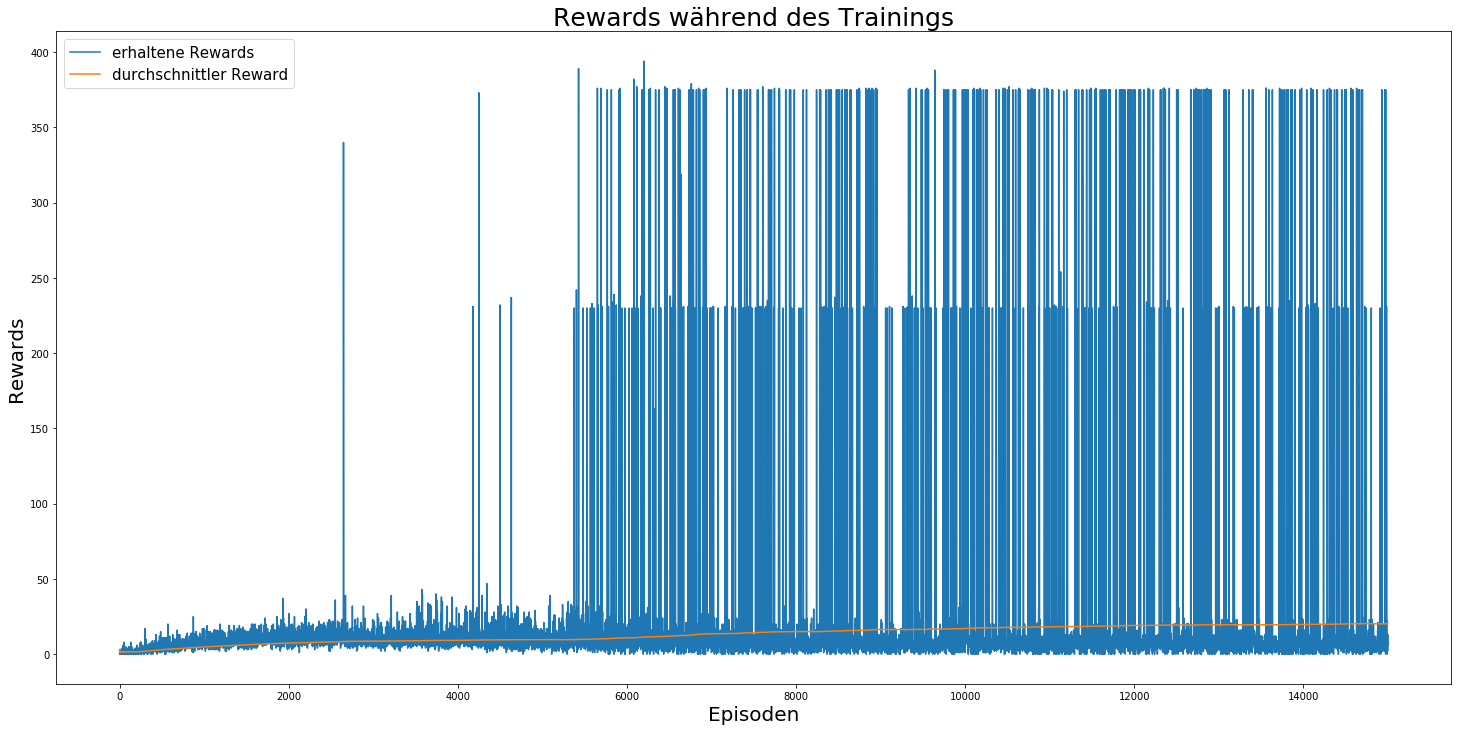

In [25]:
plt.figure(figsize=(25, 12))
plt.plot(REWARD_LIST, label="erhaltene Rewards")
plt.plot(MEAN_LIST, label="durchschnittler Reward")
plt.title("Rewards während des Trainings", fontsize=25)
plt.xlabel("Episoden", fontsize=20)
plt.ylabel("Rewards", fontsize=20)
plt.legend(fontsize=15)
plt.show()

# **Trainierten Agenten spielen lassen**

In [26]:
!ls "WEIGHTS/"

Breakout-v0  MsPacman-v0_DQN_End.h5  MsPacman-v0_DQN_Ep_13838.h5


In [27]:
# Gewichte laden
#WEIGHTS_PATH = "WEIGHTS/Pong-v0_DQN_Ep_14840.h5"
#DQN.load_weights(filepath=WEIGHTS_PATH)

## Rendering a Game

In [28]:
import gym
from IPython import display
import matplotlib
%matplotlib inline

for i in range(1):
    state = env.reset()
    done = False
    while not done:
        img = plt.imshow(env.render(mode='rgb_array'))
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        action = np.argmax(DQN.predict(state))
        state, reward, done, info = env.step(action)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

